# ING Hubs Hackaton

29.01.2021

Jaime Elguero, Santiago Gil, Borja Serra

# Open AIGym

[Gym](https://gym.openai.com/) is a toolkit for developing and comparing reinforcement learning algorithms. It makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano.

The gym library is a collection of test problems — environments — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

[Environments](https://gym.openai.com/envs/#classic_control) 

In [2]:
!pip37 install gym
!pip37 install pandas
!pip37 install numpy
!pip37 install matplotlib

zsh:1: command not found: pip37
zsh:1: command not found: pip37
zsh:1: command not found: pip37
zsh:1: command not found: pip37


In [18]:
import gym

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from termcolor import colored

import joblib
from sklearn.cluster import KMeans

There is a lot of nice environments to work with:

### Mountain Car environment

For this Hackaton, we will Focus on the **MountainCar** one. Still if your team finished before time, feel free to explore any other environment you may like

In [2]:
# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
#env.reset()
#env.seed(1); np.random.seed(1)

**Mountain Car** is a classic reinforcement learning problem where the objective is to create an algorithm that learns to climb a steep hill to reach the goal marked by a flag. The car’s engine is not powerful enough to drive up the hill without a head start so the car must drive up the left hill to obtain enough momentum to scale the steeper hill to the right and reach the goal.

In [3]:
from IPython.display import Video

Video("mountain_car.mp4")

Here we have more detailed information about it, especially focused to inputing a RL algorithm (actions, reward, etc.)

In [4]:
print(gym.envs.classic_control.mountain_car.MountainCarEnv.__doc__)


    Description:
        The agent (a car) is started at the bottom of a valley. For any given
        state the agent may choose to accelerate to the left, right or cease
        any acceleration.

    Source:
        The environment appeared first in Andrew Moore's PhD Thesis (1990).

    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07

    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right

        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.

    Reward:
         Reward of 0 is awarded if the agent reached the flag (position = 0.5)
         on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 

### A random agent to interact with the environment

- The state of the environment is the tuple **(position, velocity)**. As an starting point we will start with a null velocity and somewhere around the center of the valley (what is randomly aprox. -0.5)

In [5]:
state = env.reset()
print (state)

[-0.47923433  0.        ]


- The boundaries of our observation space are the follows:

In [7]:
env.observation_space.high

array([0.6 , 0.07], dtype=float32)

In [8]:
env.observation_space.low

array([-1.2 , -0.07], dtype=float32)

- And we also have the information of the possible actions we can perform, in this environment only 3 (see doc above):

In [11]:
env.action_space

Discrete(3)

In [2]:
import gym

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from termcolor import colored

import joblib
from sklearn.cluster import KMeans

- With all this, we have the enough information to navigate through the environment:

In [3]:
class StateActionEncoder:
  """
  Dummy state, action encoder.
  Please override!
  """

  def encode_state(self, s):
    return s, np.array2string(s, precision=2)

  def encode_action(self, s):
    return s
    #return np.array2string(s, precision=2, separator=',')

  def decode_action(self, s):
    return s
    #return np.fromstring(s.replace("[","").replace("]",""), sep=',')

In [4]:
class Agent:
  """
  Base reinforcement learning agent with basic interface
  """
  def __init__(self, learning_rate=0.25, num_state_clusters=8):
    self.learning_rate = learning_rate

    # Two-level dictionaries
    self.v = dict() # [state => reward]
    self.a = dict() # [state => action => reward]
    self.state_machine = dict() # [state => state' => action]

    # Binding state and action encoder (np.array => str)
    self.encoder = StateActionEncoder()

    # Clusters of 
    self.num_state_clusters = num_state_clusters
    self.stateHashToState = dict()
    self.kmeans = None
    self.cluster_best_actions = dict()


  def revise_clusters(self):
    """
    Given the knowledge of the observations so far,
    re-train the cluster of states and their most likelihood of best action
    """
    dataset = []
    best_action = []

    print("Building {} state clusters from {} states".format(
      self.num_state_clusters,
      len(self.stateHashToState)))
    for statehash,state in self.stateHashToState.items():
      dataset.append(state)
      a = self.best_action_from_statehash(statehash, [])[0]
      if a != -1:
        best_action.append(a)
    
    dataset = np.array(dataset)
    print("Dataset dimension : {}".format(dataset.shape))

    # Build KMeans clusters
    print("Fitting KMeans")
    self.kmeans = KMeans(n_clusters=self.num_state_clusters, max_iter=200, tol=0.0001, copy_x=True, n_jobs=4)
    self.kmeans.fit(dataset)
    clusters = self.kmeans.predict(dataset)

    # Collect most selected best actions from each cluster
    cluster_best_actions = {cid: [] for cid in range(self.num_state_clusters)} # [cluster_id => list[actionhash]]
    for c,a in zip(clusters, best_action):
      if best_action != -1:
        cluster_best_actions[c].append(a)

    def get_best_actions(cnt):
      tops = [i for i,freq in cnt.most_common(1)] #if i!=-1]
      if len(tops)==0:
        return -1
      else:
        return tops[0]

    # TAODEBUG:
    cluster_action_counter = {c: Counter(ws) for c,ws in cluster_best_actions.items()}
    print(cluster_action_counter)

    # Take the best 2 actions to take for each cluster
    self.cluster_best_actions = {c: get_best_actions(Counter(ws))  \
      for c,ws in cluster_best_actions.items()}

    pop = Counter(clusters)
    for c, best_actions in self.cluster_best_actions.items():
      print("... Cluster #{} - {:4.0f} states => Best action : {}".format(
        c,
        pop[c],
        best_actions))

  def reset(self):
    """
    Reset all internal states
    """
    pass

  def learn(self, state, action, actions, reward, next_state):
    """
    Learn that:
    - If we take an action (int) on the state (np.array)`
    - we will get back the reward (double value)
    - and register the next state (np.array)
    """
    pass

  def best_action_from_statehash(self, statehash, actions):
    best_action = -1
    best_reward = 0

    # First time visiting this state, generate initial rewards for all actions
    if statehash not in self.a:
      self.a[statehash] = {self.encoder.encode_action(act): np.random.normal(0,1e-6)\
        for act in actions}

    for a,r in self.a[statehash].items():
      if r >= best_reward:
        best_action = a
        best_reward = r
    return best_action, best_reward

  def best_action(self, state, actions, silence=False):
    """
    Return the best action to take on the specified state 
    to maximise the possible reward
    """
    statevector,statehash = self.encoder.encode_state(state)

    if statehash not in self.state_machine:
      if self.kmeans is None:
        # Unrecognised state, return no recommended action
        return (-1, 0)
      else:
        # Assume the closest state from experience
        closest = self.kmeans.predict([statevector])[0]
        action = self.cluster_best_actions[closest]

        return action, 0

    best_action, best_reward = self.best_action_from_statehash(statehash, actions)
    return (best_action, best_reward)

  def get_v(self, statehash):
    """
    Evaluate the reward value of `state`
    """
    if statehash not in self.v:
      return None
    else:
      return self.v[statehash]

  def save(self, path):
    with open(path, "wb") as f:
      print("Saving the agent to {}".format(path))
      joblib.dump(self, f, compress=1)

  @staticmethod
  def load(path, default):
    if os.path.isfile(path):
      with open(path, "rb") as f:
        print("Agent loaded from {}".format(path))
        return joblib.load(f)
    else:
      print("No agent file to load, created a new one")
      return default


class TDAgent(Agent):
  """
  Temporal difference
  """
  def __init__(self, encoder=StateActionEncoder(), learning_rate=0.8, alpha=1.0, num_state_clusters=8):
    super().__init__(learning_rate, num_state_clusters)
    self.alpha = alpha
    self.encoder = encoder

  def learn(self, state, action, actions, reward, next_state):
    statevec,statehash = self.encoder.encode_state(state)
    _,newstatehash     = self.encoder.encode_state(next_state)
    actionhash         = self.encoder.encode_action(action)

    old_v = self.get_v(statehash) or 0
    new_v = self.get_v(newstatehash) or old_v

    # Update state v matrix
    diff = self.learning_rate * (reward + self.alpha * new_v - old_v)
    self.v[statehash] = old_v + diff
    self.stateHashToState[statehash] = statevec

    # Update state transition
    if statehash not in self.state_machine:
      self.state_machine[statehash] = {}
    self.state_machine[statehash][newstatehash] = actionhash

    # Update state action
    if statehash not in self.a:
      self.a[statehash] = {self.encoder.encode_action(a): np.random.normal(0, 1e-6) for a in actions}
    self.a[statehash][actionhash] = old_v + diff

In [5]:
# env.reset();

# for i in range(200):
#     # We can visually render the current observation
#     env.render()
#     # We select a random action
#     action = np.random.randint(0, env.action_space.n)
#     # We apply the action, and receive information from the environment
#     state, reward, done, info = env.step(action)
    
# # We close the environment
# print("Closing environment")
# env.close()

In [14]:
class Game:

  def __init__(self, 
    gymenv="MountainCar-v0",
    path="dummy.agent",
    init_model=TDAgent(encoder=StateActionEncoder(), learning_rate=0.8, alpha=0.9),
    actions=[],
    max_iter=500,
    protect_first_iters=200,
    max_consecutive_decrease=7,
    train_kmeans_after=10,
    train_kmeans_every=2):

    self.env = gym.make(gymenv)
    self.agent = Agent.load(path, init_model)
    self.actions = actions
    self.max_iter = max_iter
    self.protect_first_iters = protect_first_iters
    self.max_consecutive_decrease = max_consecutive_decrease

    self.path = path
    self.train_kmeans_every = train_kmeans_every
    self.train_kmeans_after = train_kmeans_after

    print("Env created")
    print("Agent knows {} observations".format(len(self.agent.v)))

  def run(self,n_episodes=5000):

    # Start!
    print("Starting the learning episodes")
    best_reward = 0
    for i in range(n_episodes):
      
      observation = self.env.reset()
      print("Episode {} of {} ...".format(i+1, n_episodes))
      
      n = 0
      done = False
      last_action = -1
      last_state = None
      total_reward = 0

      last_reward = 0
      num_consecutive_reduction = 0

      while not done:
        n = n+1
        self.env.render()
        action,_ = self.agent.best_action(observation, self.actions)
        
        # Take supervised action
        if n<100:
            [pos, v] = observation
            if v<0: # Going left
                action = 0
            else:
                if pos < 0.4: # Not reached the flag
                    action = 2
                else:
                    action = 0
        else:
            # If the bot does not know how to react,
            # random from the action space
            if action == -1:
              # Take random action, blindly
              action = self.actions[np.random.choice(len(self.actions))]
            elif action is None:
              # Random action too
              action = self.env.action_space.sample()
            else:
              action = self.agent.encoder.decode_action(action)

        new_observation, reward, done, info = self.env.step(action)
        
        # Override the reward by how close we're to the flag
        [pos, v] = new_observation
        if pos>0.4 and pos<0.5:
            reward = abs(0.5-pos)
        elif pos==0.5:
            reward = 1
        elif pos>0.5:
            reward = pos-0.5
        
        total_reward += reward
        
        _,encoded_state = self.agent.encoder.encode_state(new_observation)
        if reward>=0:
            print(colored(f'action={action}, state={encoded_state}, reward={reward}'),'green')
        else:
            print(f'action={action}, state={encoded_state}, reward={reward}')

        if total_reward < last_reward:
          num_consecutive_reduction += 1
        else:
          num_consecutive_reduction = 0

        last_reward = total_reward

        # Record best score
        if total_reward > best_reward:
          best_reward = total_reward

        # Learn
        self.agent.learn(observation, action, self.actions, reward, new_observation)

        observation = new_observation

        if done or n > self.max_iter or ((total_reward < 0 or num_consecutive_reduction > self.max_consecutive_decrease) and n>self.protect_first_iters):
          print("... Episode DONE!")
          print("... Total reward = {}".format(total_reward))
          print("... The agent knows {} observations so far".format(len(self.agent.v)))
          self.agent.encoder.n = 0
          done = True

          if i%self.train_kmeans_every==0 and i>self.train_kmeans_after:
            # Rebuild K-Means clusters every N episodes
            self.agent.revise_clusters()

          # Save the trained agent
          self.agent.save(self.path)

          # Save the report, one line per episode
          with open("{}.log".format(self.path), "a") as f:
            f.write("{},{},{},{}\n".format(
              n, # TOL
              total_reward, # Total reward 
              len(self.agent.v), # Observation count
              sum([int(a!=-1) for c,a in self.agent.cluster_best_actions.items()]), # Num clusters with non-negative-reward best action
              ))

      print("Best score so far : ", best_reward)

In [15]:
import os
from collections import Counter

In [ ]:
game = Game(
    gymenv="MountainCar-v0",
    path="model/mountain-car.agent",
    init_model=TDAgent(
      encoder=StateActionEncoder(),
      learning_rate=0.7, alpha=0.9,
      num_state_clusters=8),
    actions=[0,1,2],
    protect_first_iters=140,
    max_consecutive_decrease=200,
    train_kmeans_after=100000000,
    train_kmeans_every=100000000)

game.run(n_episodes=10)

Agent loaded from model/mountain-car.agent
Env created
Agent knows 745 observations
Starting the learning episodes
Episode 1 of 10 ...
action=2, state=[-4.34e-01  3.41e-04], reward=-1.0
action=2, state=[-0.43  0.  ], reward=-1.0
action=2, state=[-0.43  0.  ], reward=-1.0
action=2, state=[-0.43  0.  ], reward=-1.0
action=2, state=[-0.43  0.  ], reward=-1.0
action=2, state=[-0.43  0.  ], reward=-1.0
action=2, state=[-0.43  0.  ], reward=-1.0
action=2, state=[-0.42  0.  ], reward=-1.0
action=2, state=[-0.42  0.  ], reward=-1.0
action=2, state=[-0.42  0.  ], reward=-1.0
action=2, state=[-0.41  0.  ], reward=-1.0
action=2, state=[-0.41  0.  ], reward=-1.0
action=2, state=[-0.41  0.  ], reward=-1.0
action=2, state=[-0.4  0. ], reward=-1.0
action=2, state=[-0.4  0. ], reward=-1.0
action=2, state=[-0.4  0. ], reward=-1.0
action=2, state=[-0.39  0.  ], reward=-1.0
action=2, state=[-0.39  0.  ], reward=-1.0
action=2, state=[-0.38  0.  ], reward=-1.0
action=2, state=[-0.38  0.  ], reward=-1.0
act

action=0, state=[-0.6  -0.03], reward=-1.0
action=0, state=[-0.63 -0.03], reward=-1.0
action=0, state=[-0.66 -0.03], reward=-1.0
action=0, state=[-0.7  -0.03], reward=-1.0
action=0, state=[-0.73 -0.03], reward=-1.0
action=0, state=[-0.76 -0.03], reward=-1.0
action=0, state=[-0.8  -0.03], reward=-1.0
action=0, state=[-0.83 -0.03], reward=-1.0
action=0, state=[-0.86 -0.03], reward=-1.0
action=0, state=[-0.89 -0.03], reward=-1.0
action=0, state=[-0.92 -0.03], reward=-1.0
action=0, state=[-0.94 -0.03], reward=-1.0
action=0, state=[-0.97 -0.03], reward=-1.0
action=0, state=[-0.99 -0.02], reward=-1.0
action=0, state=[-1.02 -0.02], reward=-1.0
action=0, state=[-1.04 -0.02], reward=-1.0
action=0, state=[-1.06 -0.02], reward=-1.0
action=0, state=[-1.07 -0.02], reward=-1.0
action=0, state=[-1.09 -0.02], reward=-1.0
action=0, state=[-1.11 -0.02], reward=-1.0
action=0, state=[-1.12 -0.01], reward=-1.0
action=0, state=[-1.13 -0.01], reward=-1.0
action=0, state=[-1.14 -0.01], reward=-1.0
action=0, s

action=0, state=[-0.15  0.05], reward=-1.0
action=2, state=[-0.11  0.05], reward=-1.0
action=2, state=[-0.06  0.04], reward=-1.0
action=1, state=[-0.02  0.04], reward=-1.0
action=0, state=[0.01 0.04], reward=-1.0
action=1, state=[0.05 0.04], reward=-1.0
action=1, state=[0.08 0.03], reward=-1.0
action=0, state=[0.11 0.03], reward=-1.0
action=1, state=[0.14 0.03], reward=-1.0
action=2, state=[0.17 0.03], reward=-1.0
action=2, state=[0.19 0.02], reward=-1.0
action=0, state=[0.21 0.02], reward=-1.0
action=2, state=[0.23 0.02], reward=-1.0
action=1, state=[0.25 0.02], reward=-1.0
action=2, state=[0.27 0.02], reward=-1.0
action=0, state=[0.28 0.02], reward=-1.0
action=2, state=[0.3  0.01], reward=-1.0
action=0, state=[0.31 0.01], reward=-1.0
action=0, state=[0.32 0.01], reward=-1.0
action=0, state=[0.33 0.01], reward=-1.0
action=1, state=[0.33 0.01], reward=-1.0
action=0, state=[0.34 0.  ], reward=-1.0
action=0, state=[0.34 0.  ], reward=-1.0
action=2, state=[0.34 0.  ], reward=-1.0
action=0

- A typical RL algorithm will make use of episodes as follows:

In [24]:
EPISODES = 10000

In [25]:
# Initialize variables to track rewards
reward_list = [] # Temporal one
ave_reward_list = []
successful = []
last_position_episodes = []

# Run RL algorithm
for i in range(EPISODES):
    
    # Initialize parameters
    done = False
    tot_reward, reward = 0,0
    state = env.reset()
    
    # Done will be True when:
    #  1. 200 iterations have happened OR
    #  2. The car reached the flag
    
    while done != True:
        
        # We select a random action
        action = np.random.randint(0, env.action_space.n)
        print(action)
        # We apply the action, and receive information from the environment
        state, reward, done, info = env.step(action)
        
        tot_reward += reward
    
    # We track the last position on the episode
    last_position_episodes.append(state[0])
    
    # The done condition was triggered because the car reached the flag
    if state[0] >= 0.5:
        successful.append(i)
        
    # Track rewards
    reward_list.append(tot_reward)
    
    # Show average rewards per 100 episodes
    if (i+1) % 100 == 0:
        ave_reward = np.mean(reward_list)
        ave_reward_list.append(ave_reward)
        reward_list = []
        print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
        
env.close()

0
0
2
0
0
2
0
0
1
2
1
2
0
1
1
2
0
2
1
2
2
1
2
1
0
0
1
1
0
0
1
1
2
2
2
2
0
1
0
0
1
2
1
0
0
2
0
0
2
0
1
1
2
1
0
2
2
1
2
1
1
1
2
1
2
2
2
1
1
0
1
1
0
0
1
1
1
2
2
1
1
2
1
0
1
2
2
2
1
1
2
2
2
0
2
0
0
1
1
1
2
2
2
0
1
1
1
0
1
2
2
2
2
0
0
1
0
1
0
0
0
1
1
0
1
1
1
0
2
1
1
0
1
0
2
2
2
0
0
0
0
0
1
0
1
1
2
0
1
1
2
0
2
2
1
1
2
1
2
0
1
0
1
1
2
1
2
0
0
1
0
0
1
1
0
0
2
0
1
2
2
1
1
2
1
2
1
0
0
1
2
0
1
2
1
0
2
1
1
2
2
1
1
1
2
1
0
1
1
0
1
0
1
2
1
2
2
2
0
1
0
2
1
0
2
1
0
2
0
0
2
2
1
0
1
2
0
2
0
2
0
2
0
2
0
1
0
0
1
0
0
0
1
0
2
0
2
2
2
1
0
2
0
2
1
1
2
0
2
1
0
2
1
1
1
1
1
0
0
2
2
0
2
1
2
2
0
0
0
1
1
1
2
2
0
2
1
2
2
1
0
1
1
1
0
0
2
1
2
1
1
0
0
2
0
2
2
1
0
1
1
1
2
1
2
1
0
0
2
0
1
0
1
2
2
1
2
1
1
1
1
1
2
0
2
2
2
0
2
1
0
1
2
0
0
1
2
2
0
1
2
2
1
2
2
2
0
0
1
2
1
0
1
1
0
1
2
2
2
0
0
0
0
0
0
1
2
1
1
0
1
1
0
1
1
1
2
1
2
2
1
0
2
0
2
1
0
2
0
0
0
1
2
0
2
2
1
1
2
2
0
2
2
0
0
0
1
0
1
1
1
2
1
0
0
2
1
1
0
1
2
0
0
0
0
0
1
1
2
1
1
0
0
0
2
1
1
1
2
1
2
1
0
2
1
0
0
0
2
2
2
2
2
2
0
2
2
2
1
2
0
0
1
2
0
1
0
2
1
2
0
2
2
2
0
2
1
0
0
1


2
1
0
1
2
1
2
2
1
0
2
2
0
1
1
2
0
1
2
1
1
1
2
0
0
2
2
1
2
1
1
1
0
1
1
1
2
0
1
0
0
0
2
1
1
0
1
0
1
1
1
2
1
0
2
0
1
2
1
1
0
1
0
0
2
1
2
2
1
2
1
2
1
1
2
1
1
1
1
2
0
1
2
1
0
1
2
2
2
2
2
2
2
0
0
2
0
1
2
1
2
0
2
1
2
0
1
1
2
1
0
0
1
0
1
0
1
0
2
1
0
0
2
2
2
2
2
2
2
0
0
2
2
2
2
0
0
0
0
2
0
2
1
1
2
1
2
2
0
0
0
0
0
0
0
0
1
0
1
2
0
2
2
2
0
0
2
1
1
0
1
1
1
2
0
2
1
1
2
1
1
2
2
1
0
1
0
1
2
0
1
2
0
0
2
0
2
2
0
0
1
2
0
1
0
2
0
0
1
0
2
0
2
2
1
1
1
0
1
2
0
2
0
1
0
2
1
0
0
1
1
2
0
1
0
1
2
0
1
0
2
2
1
2
2
2
2
0
2
2
1
2
0
0
2
1
1
0
0
2
1
2
0
2
1
2
1
0
2
0
2
0
1
1
0
2
0
2
1
2
2
1
2
0
0
0
2
0
0
0
2
2
1
1
1
2
2
2
1
2
1
2
2
1
0
0
2
1
1
1
0
2
0
1
2
1
1
0
1
1
1
1
1
1
0
1
0
1
2
0
1
1
1
0
0
1
2
2
0
1
0
0
0
0
0
1
0
2
1
0
1
0
2
0
0
0
1
0
1
1
0
0
0
2
1
2
0
2
1
1
1
1
0
2
0
2
1
0
0
1
1
0
2
0
1
0
2
1
2
0
0
1
0
2
1
0
0
1
0
0
1
2
1
1
2
1
0
2
2
2
0
0
0
1
2
2
2
1
2
0
1
1
0
2
2
0
2
2
2
2
2
1
1
1
1
0
2
2
0
0
2
0
1
1
2
2
2
0
1
2
1
2
1
0
2
1
1
2
0
1
0
0
1
0
1
2
2
1
2
0
1
1
1
0
2
0
2
2
2
0
2
0
1
2
2
1
1
1
0
1
2
2
2
1
0
2
1
1
0
2


1
1
0
1
2
2
1
2
0
0
2
0
1
2
0
1
1
0
2
1
1
2
1
0
2
0
1
0
0
2
0
0
2
1
2
1
0
1
1
2
2
1
1
1
1
1
1
2
1
1
1
1
1
2
1
2
0
2
1
1
2
0
0
2
0
2
0
2
1
0
0
0
2
0
2
2
2
1
2
1
1
1
0
1
2
2
0
1
0
1
1
1
1
0
1
1
2
2
1
2
2
2
1
2
1
1
2
0
0
2
0
1
0
1
1
1
2
2
2
0
0
2
1
2
2
0
1
2
2
2
0
0
2
2
2
0
2
1
1
0
1
0
2
0
1
0
2
2
1
2
0
2
0
0
2
1
0
2
2
1
0
0
1
1
1
1
2
1
0
0
2
2
2
1
1
1
1
1
1
1
0
1
0
2
2
0
0
0
0
0
2
0
1
0
0
1
0
1
2
2
2
1
1
0
0
1
1
1
0
1
1
2
2
2
1
2
0
0
2
0
1
1
2
1
1
2
2
0
2
1
0
0
1
1
1
0
1
1
2
2
0
1
1
2
2
0
1
2
2
0
1
0
0
1
1
1
1
0
0
2
1
1
2
0
0
2
1
1
1
2
0
0
1
0
1
1
2
0
1
1
2
0
0
0
1
2
2
2
2
1
2
0
0
1
1
2
2
0
0
0
2
0
1
0
1
1
1
0
2
1
2
0
2
2
0
0
2
2
2
2
0
1
0
0
0
0
2
2
0
0
2
1
1
2
2
1
1
2
0
2
0
2
2
2
2
0
1
2
2
1
1
2
1
1
2
1
0
2
2
1
1
1
2
2
1
2
0
1
2
0
0
0
0
1
2
2
0
0
1
0
1
1
2
2
2
1
2
1
0
1
1
1
1
2
2
1
2
0
2
0
2
1
1
2
0
1
0
1
2
1
0
0
2
1
0
2
2
1
0
0
0
0
2
0
1
0
0
2
0
1
1
0
1
2
1
1
1
0
1
0
1
0
2
0
0
1
2
1
0
1
2
2
0
2
1
2
2
2
0
2
2
0
1
0
2
2
2
0
2
0
1
0
2
0
0
2
1
1
1
2
1
1
0
1
1
2
1
2
2
2
1
2
2
2
1
1
1
2
0
1


0
1
0
1
2
0
2
2
0
0
1
2
1
0
1
0
1
2
1
2
0
2
0
1
1
2
2
2
2
0
2
1
1
1
1
2
0
1
0
1
1
2
2
1
1
0
2
1
1
0
1
2
1
1
2
0
0
2
2
0
2
2
1
0
0
2
2
0
1
0
2
2
2
2
0
2
2
1
0
0
1
1
2
1
0
2
1
2
2
2
2
0
0
1
1
2
0
2
1
1
1
0
1
0
0
2
1
0
1
2
1
2
1
1
2
1
0
1
1
1
1
2
2
2
2
1
0
0
2
0
0
2
2
2
2
1
1
2
1
1
2
1
2
1
2
2
1
0
0
0
1
1
2
2
1
0
1
1
2
1
2
2
1
2
1
0
1
2
2
0
1
2
2
1
1
1
0
2
2
0
0
2
0
1
1
2
2
2
2
0
1
0
2
1
2
0
1
0
1
2
0
2
0
2
1
0
0
2
1
2
0
0
1
0
1
0
2
0
0
1
1
2
0
1
1
2
1
0
0
2
1
0
0
1
0
1
2
1
2
1
1
2
0
1
1
1
1
2
1
2
0
1
0
1
1
2
0
2
0
1
0
1
2
2
0
2
0
0
1
2
0
1
1
0
2
1
0
2
2
2
1
2
1
1
0
1
2
1
0
1
0
2
0
1
1
0
1
2
1
2
1
2
0
0
1
2
2
1
1
2
2
0
0
1
0
0
1
1
2
1
2
0
2
0
1
2
0
1
2
2
0
0
0
2
0
0
1
0
1
1
0
2
0
2
1
2
0
0
0
0
0
1
1
1
0
1
2
0
2
1
2
1
1
2
2
2
0
0
2
0
1
2
2
0
0
1
2
0
2
1
1
2
0
0
1
2
1
1
1
1
0
0
0
1
2
1
2
1
0
2
2
2
0
0
0
0
0
2
1
1
1
1
1
0
2
0
2
0
2
0
1
2
2
0
0
1
0
2
1
0
0
2
2
2
0
0
2
0
1
0
1
1
0
2
1
0
2
2
0
1
1
0
1
2
2
1
0
0
0
0
0
2
2
2
2
1
0
2
0
0
1
2
2
2
2
0
2
0
0
2
1
0
1
0
0
2
1
2
2
0
2
1
2
2
2
2
0
1
1
0


1
1
0
2
2
1
0
0
1
1
1
1
1
2
2
1
2
0
0
0
2
0
0
0
0
0
2
0
1
2
0
2
2
1
0
0
0
0
2
2
2
0
0
2
1
0
0
2
0
0
0
1
0
2
1
2
0
1
0
1
0
2
1
0
2
1
0
0
1
0
1
2
1
2
0
2
0
2
2
0
0
0
2
1
0
2
2
2
1
0
2
0
1
2
2
1
2
2
2
2
2
0
2
1
1
1
0
2
1
0
1
2
2
0
2
1
1
2
1
0
2
0
0
1
0
0
0
0
1
2
1
2
1
2
1
2
2
1
0
0
2
2
1
2
2
1
0
1
1
1
1
2
1
1
2
1
1
2
2
0
2
0
2
2
2
2
0
1
1
0
1
1
0
2
2
1
0
0
0
2
1
1
1
2
0
0
0
0
2
2
0
0
0
1
2
2
0
0
2
0
0
0
1
0
1
2
0
2
2
1
2
2
1
1
1
2
1
1
2
2
0
1
0
2
2
0
0
0
2
1
0
2
2
2
1
1
2
0
1
1
2
1
2
0
2
1
0
1
2
0
0
0
2
0
0
0
1
1
0
2
0
2
2
1
0
2
1
0
2
2
2
1
2
1
1
2
1
2
0
0
0
2
2
2
1
1
1
2
1
1
0
0
1
1
2
0
2
0
1
0
1
0
2
2
1
2
0
0
2
1
0
2
2
1
0
0
1
0
1
1
2
0
0
1
0
0
2
1
1
1
2
2
2
0
0
0
1
0
1
0
2
2
2
1
0
0
0
0
1
0
2
0
1
2
2
1
1
1
0
2
0
0
2
2
2
0
2
2
0
1
1
2
2
0
2
2
1
1
2
0
1
0
0
1
2
0
1
0
0
0
0
2
0
0
1
2
2
1
2
1
2
2
0
0
1
1
2
1
2
1
2
1
1
1
2
2
0
0
2
2
0
2
1
2
1
0
0
2
0
1
1
0
2
2
1
2
2
0
0
1
1
1
2
1
1
1
2
1
0
1
1
2
0
1
0
0
2
2
1
2
0
0
1
2
1
0
2
1
1
2
0
2
1
1
0
0
1
0
1
2
2
2
0
0
1
2
2
1
0
2
0
1
2
2
1
2
0
1
0
2


0
0
2
1
1
1
0
2
2
2
2
1
2
2
2
1
1
0
1
2
1
1
0
0
2
0
0
0
1
1
2
2
1
0
0
2
2
1
2
1
1
2
2
2
1
1
2
2
0
2
1
2
2
0
1
1
2
2
2
1
0
1
2
2
2
2
0
2
0
0
0
1
0
1
2
2
2
1
2
1
1
1
1
0
0
2
2
1
0
1
1
1
2
1
2
0
0
0
1
1
2
1
2
1
2
1
1
1
1
0
2
2
0
0
1
1
1
2
1
1
0
0
2
1
2
2
0
2
1
0
1
0
2
0
0
1
1
1
2
1
0
2
1
1
1
2
0
2
0
2
0
2
0
1
0
2
2
2
1
0
0
2
2
2
0
2
1
2
0
0
0
1
0
2
2
0
2
1
0
1
1
1
2
2
0
2
1
2
0
0
2
2
2
1
0
1
1
1
1
0
0
1
0
2
1
0
0
1
1
2
2
0
2
0
0
1
2
2
0
0
2
2
0
2
0
0
2
1
0
1
1
0
1
2
1
1
1
2
2
0
0
0
2
2
1
2
0
2
2
2
2
0
1
2
1
0
1
2
1
2
0
0
1
0
0
1
2
0
0
1
1
0
1
2
1
1
1
2
0
1
1
0
0
0
2
0
2
2
2
0
1
0
0
1
1
2
2
1
0
1
2
0
2
1
2
0
0
0
2
0
1
0
0
0
2
2
2
1
0
2
1
2
2
1
2
1
2
0
0
0
0
2
1
0
2
1
0
1
1
2
0
0
0
0
2
1
0
2
2
0
2
1
1
1
2
0
2
1
0
2
1
0
2
2
2
2
2
1
1
2
0
2
0
2
2
1
1
1
0
1
1
2
2
0
2
2
2
1
1
2
1
0
2
2
0
1
0
1
0
2
1
1
0
2
2
1
0
1
1
1
0
0
1
1
2
0
1
2
1
1
1
1
0
2
2
2
0
0
1
2
2
1
2
0
0
2
0
1
1
2
0
2
2
1
1
0
2
2
1
2
0
2
0
1
0
2
0
0
1
1
2
2
1
1
0
0
0
2
0
0
2
2
1
2
0
1
0
2
0
1
1
2
1
0
0
2
0
0
0
0
1
1
0
0
1
2
0
0
0
1


2
1
0
0
1
0
0
0
1
0
0
0
2
0
1
0
1
2
1
0
1
2
1
1
0
2
1
0
2
0
0
2
1
2
0
2
0
2
2
0
2
1
1
2
0
2
2
2
0
1
2
1
1
1
2
0
2
1
0
1
1
1
2
1
1
0
1
0
2
1
2
2
1
1
1
0
0
1
1
1
2
0
0
0
2
2
0
0
0
0
0
1
0
1
0
2
0
2
1
1
0
0
0
1
2
0
1
1
1
0
2
1
0
1
0
0
0
1
1
2
2
2
1
2
0
2
0
2
2
0
0
2
1
1
1
0
0
2
0
0
2
1
2
1
1
0
2
2
1
2
2
2
2
0
2
1
0
1
1
0
2
2
2
2
2
0
1
0
1
2
2
0
2
0
2
2
0
2
1
2
2
1
1
2
0
0
2
1
0
0
1
2
0
1
1
1
2
2
1
0
0
1
0
0
1
0
0
1
0
2
2
1
2
1
0
2
1
2
0
2
2
1
0
0
2
0
2
0
2
1
2
2
0
1
0
2
0
0
2
0
2
0
0
2
1
0
2
2
1
2
1
1
0
0
1
2
0
0
0
2
0
0
2
1
1
1
0
2
1
2
2
1
2
2
2
0
2
1
1
2
2
2
2
1
2
1
2
0
2
1
0
1
1
2
2
1
1
1
2
0
2
0
2
1
1
0
1
1
2
2
2
1
1
1
2
1
2
1
0
2
1
1
1
1
0
1
0
2
0
0
2
2
2
1
1
1
0
1
1
1
1
1
1
1
2
0
2
1
1
2
1
0
0
0
2
2
0
1
2
2
1
2
2
1
1
2
2
2
2
1
1
0
0
0
2
0
2
1
1
1
1
1
2
2
1
2
0
2
2
1
1
1
2
1
0
2
2
1
0
0
0
1
1
2
2
0
1
0
0
0
2
0
0
1
1
1
2
2
1
1
1
2
2
1
0
1
2
1
1
2
2
0
2
2
2
2
2
2
1
1
2
2
2
0
0
0
2
1
1
2
0
0
0
0
0
0
0
0
2
0
0
1
2
2
1
1
2
1
1
2
2
1
1
1
0
1
2
1
2
1
2
2
0
2
2
2
0
2
0
0
2
0
2
2
0
0
0
0
2
1


1
1
2
1
2
0
1
1
2
0
0
2
1
1
1
0
0
2
2
0
1
1
0
0
2
0
2
0
2
1
2
1
0
2
1
2
0
1
1
1
1
1
0
0
1
1
0
2
1
0
1
2
0
2
1
0
0
0
2
1
2
0
2
0
1
2
0
0
2
0
0
1
0
2
1
0
2
2
1
2
2
0
2
0
0
1
0
2
1
2
1
2
2
2
2
2
2
0
2
0
1
2
2
0
2
1
0
2
0
0
0
1
1
0
2
1
2
1
2
1
2
0
0
2
2
0
1
2
1
2
1
2
0
0
1
0
0
0
1
2
1
0
0
2
2
0
1
2
1
1
0
0
2
2
1
1
1
1
0
1
2
2
2
0
1
2
1
2
0
0
2
2
1
1
0
0
0
0
1
2
0
0
2
0
1
2
2
2
2
2
2
1
1
0
2
2
0
2
1
0
2
0
2
2
0
1
2
0
0
0
2
1
2
2
0
2
2
0
1
2
2
1
1
1
0
2
2
2
0
1
0
0
2
1
2
0
0
2
0
2
0
2
0
0
0
1
1
1
1
0
0
2
1
0
2
0
2
0
1
0
0
1
1
1
1
1
2
2
0
2
2
0
1
1
1
2
0
1
2
0
1
1
2
2
2
2
2
1
1
2
2
1
0
0
2
0
0
0
0
0
0
1
2
2
0
2
1
2
2
1
0
1
2
0
2
2
1
0
2
2
1
0
2
0
0
1
1
1
0
2
1
1
2
1
0
0
2
1
2
2
2
1
1
0
0
0
2
0
1
1
2
2
2
0
1
1
2
0
2
1
0
2
2
0
0
2
2
1
0
1
2
0
0
2
2
2
2
0
2
0
0
1
1
2
1
1
1
0
0
1
2
2
1
1
2
0
1
2
0
2
2
2
1
1
0
0
0
2
2
0
1
0
1
2
1
1
0
2
1
2
1
2
1
0
1
0
0
0
2
2
2
2
0
2
0
0
0
0
1
0
2
0
1
1
1
1
1
2
0
2
2
1
2
1
2
1
1
1
0
0
0
2
2
2
0
0
0
0
1
1
1
1
1
1
1
2
0
1
1
0
1
2
1
2
2
0
2
2
2
0
0
0
0
0
0
1
2
0
2
0


0
2
2
2
1
2
2
2
1
2
2
1
0
0
1
2
2
0
2
0
0
1
1
0
1
0
1
1
2
1
2
2
2
0
1
2
0
1
1
2
0
2
0
2
2
0
1
0
0
2
1
2
2
0
0
0
0
2
1
2
1
2
0
1
0
2
1
1
2
1
2
2
1
1
2
0
2
0
1
0
2
2
2
0
2
0
1
2
2
0
1
0
0
1
1
0
2
2
1
2
1
2
1
1
2
2
2
2
1
0
0
0
1
1
1
0
2
2
0
1
0
1
0
2
1
2
0
1
1
0
0
2
2
0
1
2
2
1
0
2
2
0
2
2
0
2
2
1
0
0
1
2
1
2
1
2
1
0
0
0
2
0
1
0
0
2
1
1
2
2
1
1
0
0
2
1
0
0
2
0
1
2
1
0
1
0
0
2
0
1
0
0
0
0
2
2
1
1
1
2
1
1
2
2
0
1
0
2
2
2
1
2
1
2
1
2
2
1
2
0
1
2
2
2
0
0
2
0
2
2
0
1
1
2
2
1
0
2
2
0
0
1
1
2
1
2
2
0
2
1
0
1
1
1
1
2
2
1
0
1
0
2
1
1
2
0
1
0
1
0
1
0
1
2
1
1
0
1
0
2
2
2
2
0
2
0
1
2
1
1
0
2
1
2
2
2
2
0
1
2
0
0
1
2
0
2
2
0
2
0
0
2
1
2
0
1
0
0
1
2
2
2
0
0
1
2
0
0
2
0
0
2
0
2
2
0
1
0
2
0
1
2
2
2
0
2
2
2
0
2
2
1
1
0
0
0
0
0
2
1
1
2
1
0
1
2
2
1
0
1
2
2
2
0
2
1
1
2
2
2
2
1
1
1
2
2
2
1
0
2
2
1
2
2
1
2
0
1
2
2
2
2
2
2
0
1
2
0
2
2
1
2
0
0
0
0
1
1
1
1
1
1
2
2
2
0
1
0
1
0
1
1
0
0
2
0
1
0
1
2
0
0
1
0
2
2
1
0
1
2
2
2
2
1
2
1
1
2
2
0
2
2
2
1
2
1
1
1
0
2
0
0
1
1
1
1
0
0
2
0
2
0
0
1
1
0
1
2
0
2
0
0
1
1
1
1
2
1
1
2


1
0
2
0
1
2
2
0
2
2
0
0
0
2
1
0
0
0
1
2
1
1
1
1
1
1
1
1
2
1
0
0
1
2
0
2
1
0
0
1
1
1
2
1
0
0
0
0
1
0
2
0
1
2
1
0
2
2
2
1
1
0
0
0
1
2
1
0
0
1
2
2
2
0
0
2
2
1
2
2
2
2
2
0
0
1
1
1
0
2
0
1
1
1
2
0
0
1
0
0
2
2
2
0
2
2
1
1
2
2
0
2
0
1
0
0
1
1
1
0
0
2
1
0
2
2
1
0
2
2
1
1
2
2
2
1
1
0
2
2
0
2
2
0
2
1
0
1
1
2
1
2
1
0
2
2
1
1
2
1
0
2
2
2
2
2
1
1
0
2
2
0
1
0
2
2
2
0
0
1
1
2
1
2
0
0
2
2
0
1
0
2
2
2
0
2
0
1
0
2
0
2
2
0
2
0
2
1
2
1
1
0
1
2
0
1
1
2
1
0
0
2
2
1
2
2
1
2
0
0
2
0
2
0
1
0
2
2
0
2
1
2
1
2
0
0
1
1
1
0
0
2
2
2
2
0
2
0
2
2
2
2
2
2
0
0
1
1
0
1
1
1
1
2
2
0
2
2
0
1
1
1
2
1
0
0
0
0
0
2
2
2
2
0
0
1
1
2
1
2
2
1
1
0
0
2
2
2
0
0
2
1
2
0
0
0
0
1
0
0
2
1
1
2
1
0
0
2
1
1
2
0
1
1
0
0
0
0
0
0
2
0
0
2
1
1
1
0
1
2
1
0
0
0
1
0
1
1
2
1
0
0
0
1
0
1
2
1
1
2
2
2
1
0
0
2
2
2
0
1
1
2
1
2
0
2
1
0
2
2
1
2
0
0
1
0
0
0
1
2
1
1
2
1
1
1
0
1
0
1
1
0
1
0
1
1
0
2
2
0
0
2
1
0
0
2
0
0
2
1
2
2
2
1
1
2
1
2
2
2
1
2
2
1
2
2
0
0
1
0
0
2
1
2
1
2
2
0
0
1
1
0
2
1
2
0
1
0
1
0
1
2
1
1
0
2
1
0
0
2
0
0
2
2
0
1
0
1
2
2
2
0
1
2
1
1
2
2
2
0


2
0
2
0
1
0
2
2
2
0
1
2
0
1
2
1
0
0
0
0
1
0
2
0
0
0
2
2
1
2
2
1
0
1
2
2
1
2
1
2
1
1
1
2
0
0
1
1
0
0
1
2
2
2
0
1
0
1
1
1
1
0
1
1
0
2
2
2
2
1
1
0
0
2
0
0
2
2
0
0
1
2
0
1
2
0
2
0
1
2
1
0
2
2
2
0
2
1
1
1
0
1
0
2
0
2
1
2
2
1
0
0
0
2
1
2
0
1
1
1
0
1
1
0
0
1
2
2
1
1
1
1
0
0
0
2
0
2
2
2
0
0
2
1
1
2
2
2
1
0
2
2
1
0
1
1
1
0
1
1
0
0
0
1
0
2
0
2
1
2
1
1
2
2
1
2
2
1
1
1
1
0
0
0
1
0
1
1
1
2
2
2
2
1
1
2
1
1
2
0
2
2
1
1
1
2
0
0
2
0
2
0
1
0
1
2
2
1
2
1
0
0
0
2
2
0
0
2
2
2
0
1
1
2
2
1
1
1
0
2
1
0
2
1
0
0
0
0
1
2
2
0
1
2
0
0
0
2
0
0
1
2
0
1
1
2
1
1
0
1
0
2
0
2
2
0
2
0
1
1
2
1
0
0
0
1
0
1
0
0
1
0
1
2
2
1
1
0
1
1
0
1
0
2
1
1
0
0
0
0
2
0
0
1
1
0
0
1
1
1
2
2
1
0
2
2
2
1
0
2
0
0
1
0
2
2
0
2
0
0
2
0
2
0
0
0
2
2
0
0
1
2
2
1
0
0
0
2
2
0
1
2
1
2
0
0
0
1
1
0
0
1
0
1
0
1
0
1
1
0
0
2
2
1
0
2
1
1
0
0
1
1
0
2
0
2
1
0
1
0
1
0
0
1
1
0
0
2
1
0
2
0
1
2
0
1
2
2
1
1
0
0
1
1
2
1
1
1
2
0
0
1
1
2
2
1
2
0
0
2
1
0
1
0
2
1
0
1
0
2
0
1
0
1
2
2
0
2
1
2
2
1
0
0
0
2
0
1
2
1
2
1
0
0
0
1
1
0
2
2
2
1
0
0
0
2
1
2
1
1
2
2
1
2
0
1
1
2
1
1


2
1
1
2
1
0
2
0
1
2
0
2
2
2
2
2
0
0
0
2
0
2
2
1
1
0
2
1
2
2
1
1
1
2
0
0
0
2
0
0
1
2
0
0
1
0
1
0
0
0
0
1
2
1
0
2
2
1
2
2
2
2
1
1
0
0
2
0
0
1
2
0
1
1
2
1
1
2
2
1
0
0
1
0
1
2
2
0
2
0
1
0
0
2
0
1
2
0
0
0
1
0
2
1
0
1
2
2
0
1
2
2
2
2
2
0
2
2
1
1
1
2
1
0
0
2
1
1
1
1
2
2
1
0
0
2
0
2
1
2
1
1
2
1
2
1
0
2
2
0
0
2
0
1
0
0
2
2
0
1
0
0
1
1
1
0
1
2
2
0
0
2
0
1
0
2
0
2
0
1
1
1
0
0
0
1
2
0
2
1
1
0
1
2
1
0
0
2
0
0
2
1
0
2
1
1
2
2
0
0
2
0
2
2
1
0
1
1
2
1
1
2
2
2
1
2
0
2
1
1
1
2
2
0
0
2
1
2
1
1
2
2
0
2
2
2
0
2
2
0
1
1
2
2
0
1
1
0
1
1
1
2
2
2
1
1
1
1
1
0
0
2
1
0
0
2
2
0
0
1
1
1
0
0
1
0
2
2
0
0
0
0
0
2
1
1
0
1
1
2
2
0
1
2
1
1
0
0
0
2
0
2
1
0
0
2
1
0
1
1
1
0
0
0
2
2
2
1
2
2
1
2
0
1
0
2
1
1
0
1
0
1
2
1
1
0
1
0
0
0
1
1
1
0
1
2
2
0
1
1
0
0
0
0
2
0
1
0
1
2
0
1
2
0
0
1
0
1
2
2
2
2
2
1
2
0
1
2
0
0
2
0
2
1
0
1
2
1
0
0
0
0
0
2
1
1
0
1
1
1
2
2
1
2
0
1
2
2
2
2
2
1
2
1
2
2
2
1
0
0
1
2
2
1
1
0
0
0
1
2
1
2
0
0
1
2
0
0
2
0
2
0
2
1
1
1
0
1
1
0
2
1
1
0
0
1
1
2
2
1
2
2
2
1
1
2
0
1
1
0
2
1
0
1
0
0
2
1
0
2
1
0
2
0
0
1
1
2
2
1


1
0
2
0
0
0
0
2
2
0
2
2
1
0
1
1
1
1
1
1
0
2
0
2
0
0
1
2
0
0
2
2
2
1
2
1
1
0
0
0
1
0
0
1
1
2
2
0
1
1
0
1
2
0
2
1
1
1
0
1
0
1
1
1
0
0
2
0
2
2
2
1
1
1
1
2
1
1
1
2
0
2
0
2
2
1
0
1
1
2
0
1
1
2
0
1
1
1
1
0
1
0
1
2
2
2
1
2
0
0
1
0
0
2
1
1
0
1
1
2
2
2
0
2
1
2
1
0
0
0
1
1
2
1
1
1
1
1
1
0
2
2
0
0
2
1
1
0
1
1
2
1
1
2
1
1
0
2
2
0
0
2
1
0
1
1
0
0
0
1
2
2
0
2
2
0
1
0
1
2
0
2
2
1
1
1
0
1
1
0
0
1
1
0
1
2
0
1
1
0
2
0
0
0
0
0
0
2
2
0
2
1
0
2
1
0
1
0
1
0
0
0
2
0
2
1
1
1
1
1
1
0
1
0
2
2
0
1
0
0
0
2
1
0
0
2
2
1
1
2
0
0
0
1
1
2
1
2
2
2
1
2
1
1
1
1
1
0
0
2
0
1
1
0
0
0
2
2
1
0
2
2
1
0
0
1
1
1
1
2
0
0
2
1
2
1
2
1
0
1
0
0
2
2
1
2
1
0
2
1
0
1
2
1
0
2
2
1
2
2
2
0
0
1
0
2
0
1
2
1
0
1
2
1
0
1
0
1
2
1
1
1
0
1
0
1
1
1
1
2
0
1
0
1
0
2
1
2
2
2
1
1
2
1
0
1
2
1
2
0
1
2
1
0
2
1
1
1
2
0
1
0
2
2
2
0
0
0
2
2
1
0
2
1
1
1
0
1
1
2
2
0
2
0
2
1
1
1
0
0
0
0
1
1
0
0
2
2
1
2
0
0
2
0
1
2
1
1
2
0
2
2
1
1
0
1
1
2
2
2
0
0
2
1
0
1
1
1
1
1
0
2
2
2
0
1
2
2
2
0
1
1
0
1
2
2
1
1
0
2
2
1
2
0
0
1
0
1
2
1
2
1
0
0
2
1
0
2
2
2
1
2
1
0
2
1
2
0
0
2


2
2
1
1
1
1
1
1
2
1
0
0
2
0
1
0
0
2
0
0
2
0
0
0
1
0
0
2
0
0
2
1
2
0
2
1
2
1
0
1
0
0
1
0
2
0
2
2
0
1
2
2
2
1
1
1
2
2
1
0
1
1
0
2
2
2
1
0
0
1
0
2
1
2
1
0
0
1
0
0
0
1
0
2
1
1
2
0
1
1
0
1
0
2
1
1
1
0
0
0
0
1
2
1
1
0
1
0
2
2
2
0
2
1
2
0
2
2
1
0
2
2
2
0
1
1
2
2
0
1
2
1
0
1
0
1
0
1
2
1
2
2
0
2
1
2
0
1
1
1
2
2
1
1
2
2
2
1
0
2
1
0
2
2
1
1
2
1
2
2
1
0
2
0
0
0
2
1
2
0
0
0
0
1
2
2
0
1
1
1
2
1
0
0
2
2
1
1
1
1
0
0
2
2
0
1
0
0
0
2
1
0
1
2
0
0
0
1
1
0
2
0
2
1
2
2
0
0
0
2
1
1
1
2
0
1
1
1
0
2
1
0
2
2
0
0
0
0
0
0
1
0
1
1
0
2
0
2
1
1
1
2
1
0
2
2
0
2
0
1
2
0
1
1
1
0
1
1
2
2
0
1
1
0
1
1
1
1
0
0
1
0
1
0
2
2
2
0
0
0
1
0
1
1
1
1
0
0
0
0
1
1
1
2
2
2
1
2
2
0
2
1
0
2
2
2
1
2
0
2
0
1
2
0
2
1
2
0
2
1
2
0
0
1
0
2
0
0
0
0
1
2
1
0
2
1
1
0
0
2
2
0
2
2
1
2
0
0
1
2
0
1
2
0
1
1
1
0
0
2
1
2
2
0
2
1
2
1
2
1
1
2
1
1
2
1
2
2
1
0
2
2
2
0
2
2
0
1
1
0
0
0
0
1
1
2
2
0
0
0
2
2
0
0
0
2
0
2
1
2
2
1
2
2
2
1
0
2
1
2
2
0
1
1
2
0
1
2
2
1
0
2
0
2
2
2
2
1
1
0
0
0
1
2
1
2
1
2
1
1
0
0
2
2
0
2
2
2
1
2
0
2
2
0
0
2
0
1
2
0
2
0
1
0
2
1
0
2
0
1


1
2
0
2
2
1
2
2
1
0
2
2
0
1
1
2
1
2
0
1
1
0
2
2
0
2
2
2
1
2
0
1
0
1
0
1
2
0
1
1
1
0
1
2
1
0
2
1
2
0
0
1
0
0
1
0
1
0
2
0
2
2
0
2
2
0
1
0
1
0
1
0
1
0
0
0
1
0
0
2
2
0
1
2
0
1
2
2
2
2
2
2
0
0
0
1
2
2
0
1
0
2
1
2
0
2
0
1
2
0
2
2
2
1
2
0
1
0
0
1
0
2
0
1
2
0
1
0
1
1
2
1
0
0
1
0
2
2
0
0
1
2
0
1
2
2
1
0
0
0
0
2
0
1
1
2
0
0
2
0
1
0
0
0
1
1
1
2
2
1
0
2
1
1
1
2
1
0
2
1
0
1
1
0
1
2
1
0
0
1
2
0
2
1
0
1
0
0
2
2
2
1
1
0
0
0
1
0
0
2
2
2
2
0
0
2
1
1
2
1
1
0
0
1
2
2
1
2
0
0
0
2
0
2
1
1
1
2
1
2
2
1
1
0
1
1
1
0
0
2
0
1
2
1
1
0
1
1
2
2
1
2
2
0
0
0
2
2
2
0
0
0
0
2
0
0
2
0
2
0
2
2
0
1
2
0
0
1
1
2
1
2
2
0
2
2
2
0
2
0
0
0
1
2
2
1
2
1
0
2
1
0
2
2
2
0
0
1
1
2
2
1
0
0
2
2
2
1
2
1
0
1
1
2
1
2
2
2
1
2
2
0
1
0
0
2
0
1
0
1
1
1
0
1
1
2
0
2
1
2
1
2
1
0
1
2
2
2
0
0
2
2
1
0
1
0
0
1
1
1
2
1
2
2
1
1
2
2
0
0
1
0
2
0
2
0
2
2
1
1
1
0
0
1
0
0
0
0
2
0
2
0
1
1
2
1
2
1
0
1
1
1
2
1
1
1
2
2
2
1
1
2
1
2
1
0
2
0
1
2
1
2
0
1
0
1
0
0
0
1
1
0
2
1
1
1
2
0
2
2
0
2
1
0
0
2
0
0
0
2
0
2
2
1
1
2
0
2
1
2
0
0
0
2
2
0
0
1
2
1
0
1
2
2
0
0
2
0
0
0


1
2
2
0
1
1
2
2
2
1
2
2
2
1
2
2
0
2
1
0
1
0
2
1
1
2
1
2
1
2
1
0
0
1
2
0
2
2
1
2
0
2
2
1
2
1
0
2
1
0
1
0
2
1
0
2
2
2
0
0
0
2
2
1
2
2
2
2
2
0
0
2
1
1
2
1
0
0
1
1
0
2
1
2
2
1
2
1
2
0
2
2
0
0
1
2
2
2
1
2
1
1
2
0
0
0
2
0
2
1
2
2
1
1
1
2
2
1
2
2
2
1
2
0
0
1
1
0
0
1
2
2
0
0
2
0
0
0
0
2
2
1
1
0
2
1
1
0
2
1
2
2
2
1
0
1
2
1
0
1
0
1
2
2
2
1
0
1
0
0
1
0
2
2
0
1
0
1
2
2
2
1
0
0
0
1
1
2
1
2
0
2
0
0
2
0
2
0
0
0
0
1
0
0
0
1
2
2
2
1
1
0
0
1
0
1
2
0
1
0
1
0
1
2
1
0
1
1
2
1
2
0
2
1
2
0
1
0
0
0
2
0
0
2
2
2
0
1
0
0
0
2
0
1
1
0
2
1
2
0
1
0
1
0
1
2
0
0
1
1
1
1
0
2
1
0
2
0
1
1
0
0
2
1
2
1
0
2
1
1
2
0
1
2
0
2
2
1
1
1
2
1
1
0
2
1
0
1
2
1
1
2
1
1
0
1
1
0
0
0
2
1
2
1
1
1
0
0
2
0
2
2
2
0
0
1
1
2
2
2
0
2
1
0
0
1
2
0
2
1
2
2
0
2
1
0
1
0
0
1
0
1
0
1
0
0
1
0
2
0
2
0
1
1
1
1
2
2
2
0
1
2
1
1
0
0
1
2
2
0
0
0
2
2
1
2
1
1
0
1
1
1
1
1
1
1
1
0
1
1
2
2
1
0
0
1
2
2
2
0
0
1
2
1
1
1
1
2
1
0
2
1
1
0
0
0
2
2
2
2
0
1
2
2
0
2
2
2
0
2
1
0
2
1
1
2
2
2
2
1
0
0
1
1
2
1
2
2
1
1
0
2
2
2
2
2
1
1
2
2
2
2
1
2
1
2
2
2
2
1
1
1
1
2
0
1
0
2
0
1


2
2
2
2
2
2
1
0
2
2
0
1
2
2
1
0
1
0
2
0
2
2
0
0
2
2
1
2
0
1
2
1
1
1
2
0
0
1
1
0
2
2
1
2
1
1
2
1
2
0
1
0
2
0
0
2
1
2
1
1
2
2
2
1
1
2
0
2
2
2
0
2
1
0
1
1
2
2
0
1
0
2
0
1
0
1
2
2
1
2
0
2
0
2
2
2
2
0
1
1
2
0
0
1
1
0
2
2
1
2
1
1
1
0
2
0
1
1
0
1
2
0
2
1
0
0
2
1
1
0
1
0
2
1
2
2
1
2
0
2
2
2
2
2
2
1
1
1
1
1
2
0
2
1
1
1
2
1
2
1
0
1
2
1
0
1
0
0
1
0
1
0
2
2
2
0
2
0
0
1
2
2
0
0
0
2
0
1
2
0
1
0
0
2
0
2
2
1
1
1
1
2
1
1
0
0
2
0
0
1
1
0
0
0
0
2
2
1
0
1
0
0
1
2
0
1
2
1
2
2
0
2
2
2
2
0
2
1
0
2
1
1
1
0
0
0
1
2
2
1
1
2
2
2
1
1
1
0
1
0
1
2
2
2
0
2
1
2
1
0
0
1
2
2
2
1
2
2
2
0
1
2
1
2
0
0
1
0
0
0
2
2
2
0
2
1
2
2
1
1
0
0
1
0
1
0
2
2
1
0
0
0
0
0
2
1
0
0
1
0
0
2
0
0
1
1
0
2
0
0
1
2
2
0
2
2
2
1
0
2
0
2
2
2
0
0
1
2
2
2
1
2
0
0
2
0
1
1
1
1
0
0
2
0
0
0
1
0
1
2
2
0
1
1
2
0
0
1
2
2
0
0
1
1
2
0
2
2
1
1
1
1
2
0
2
0
0
1
1
2
1
2
0
1
0
0
1
1
0
0
2
1
1
1
1
1
1
2
2
0
2
2
2
0
0
1
0
1
2
1
2
1
2
0
1
2
2
0
0
2
0
1
2
2
1
2
2
1
0
1
2
2
1
0
2
2
2
1
0
1
0
0
0
0
1
2
0
1
2
1
0
0
0
2
2
0
2
1
0
1
1
2
1
1
1
2
0
2
0
0
2
0
2
0
2
0
2
2
2
1


1
1
0
0
2
0
1
0
1
2
0
1
0
0
0
2
1
1
0
2
1
2
2
1
0
0
2
1
1
2
2
1
0
2
1
2
2
2
1
1
1
1
1
1
1
0
1
1
0
2
0
2
0
1
2
1
1
2
0
0
0
2
0
1
1
2
2
2
0
2
1
2
2
1
0
0
1
0
1
0
0
1
2
0
0
0
0
0
1
1
0
2
2
2
1
1
2
2
1
0
2
1
1
2
0
2
1
0
2
0
2
0
1
1
2
1
1
0
1
0
1
0
1
1
1
2
1
0
2
1
2
1
1
2
2
1
2
1
1
2
2
2
0
1
0
2
2
2
1
0
0
0
2
0
2
2
1
0
1
1
2
1
2
1
2
2
1
0
1
0
1
2
1
2
2
0
2
2
1
0
1
2
1
0
0
2
1
0
0
1
1
0
1
1
2
2
1
2
2
1
1
0
2
2
2
0
1
0
0
1
2
0
0
0
1
2
1
0
2
1
2
0
0
0
0
2
1
0
0
2
0
1
2
1
0
2
0
1
1
1
1
0
2
0
2
2
1
1
2
0
1
0
2
0
0
2
2
2
1
0
1
0
1
2
2
2
0
1
1
1
2
2
0
1
0
1
0
0
0
2
0
2
0
2
2
0
0
1
2
0
0
2
1
0
1
0
2
1
0
1
2
2
2
0
0
2
2
0
1
0
2
1
2
1
0
2
2
0
1
1
0
0
0
1
1
2
0
0
2
2
2
2
0
0
2
0
1
2
2
0
2
2
1
2
2
0
2
0
2
1
1
1
0
0
0
1
2
0
1
1
0
1
1
0
1
0
2
2
2
2
1
0
1
2
1
0
0
1
1
2
2
1
1
2
0
2
2
0
1
0
2
2
2
0
1
2
1
2
0
1
1
0
1
2
0
0
1
0
1
2
0
0
2
2
1
2
0
1
0
1
0
1
1
0
0
2
1
2
1
0
0
1
2
2
2
1
0
1
0
2
2
2
1
0
2
2
1
1
0
1
0
2
1
2
0
1
1
0
0
1
1
2
1
2
1
2
0
1
0
2
0
0
1
1
0
2
2
1
1
0
1
1
0
0
0
0
2
1
0
2
2
0
2
1
2
1
2
0
1
2


2
0
0
2
0
0
0
0
1
2
1
0
1
1
2
2
0
0
1
2
2
2
0
2
1
2
0
1
0
2
2
1
0
1
0
1
2
0
1
2
2
0
1
1
1
0
1
0
1
2
2
2
2
2
0
0
0
2
1
2
2
2
1
2
0
2
0
1
0
0
1
0
1
1
1
2
0
0
0
2
0
0
2
1
1
1
0
2
2
1
0
2
0
1
1
0
0
0
2
1
1
2
0
2
0
0
1
2
2
0
0
2
0
1
0
0
0
0
0
0
1
2
1
0
2
1
1
2
2
2
0
1
1
0
1
1
0
2
0
0
2
0
2
1
2
1
1
0
2
2
2
1
1
1
0
2
1
1
1
1
0
2
1
1
0
1
1
2
1
1
2
0
1
2
2
0
1
1
0
1
1
2
0
1
0
0
1
1
2
2
1
1
1
0
1
1
2
1
1
2
2
1
1
1
0
1
1
0
0
1
2
2
0
0
0
1
1
0
0
2
1
0
0
1
1
1
2
0
1
0
0
2
1
2
0
0
0
1
1
0
0
1
0
2
2
1
1
2
0
2
1
0
0
0
1
2
2
2
0
0
0
0
2
2
0
0
2
2
2
0
2
0
1
2
0
0
2
0
1
0
0
0
1
2
1
0
2
0
0
1
2
2
0
0
0
1
2
0
1
0
0
2
0
0
0
1
1
0
0
0
0
1
0
2
1
Episode 400 Average Reward: -200.0
0
0
2
1
2
1
0
0
1
1
1
2
2
1
0
1
1
2
0
2
0
2
0
2
0
1
1
0
0
0
0
0
0
0
1
1
0
0
2
1
2
0
1
0
1
2
2
2
1
0
1
1
2
0
2
2
2
1
0
0
2
2
2
2
1
0
2
0
2
2
1
0
2
1
1
1
1
2
2
2
2
0
1
1
1
0
0
0
1
0
0
1
1
0
1
0
1
1
2
0
2
1
1
0
2
1
1
2
0
0
0
2
0
2
0
0
0
1
1
0
1
0
0
0
1
0
0
2
2
1
1
2
1
1
1
1
1
2
0
2
2
0
2
1
1
0
0
0
2
0
2
0
1
2
1
0
1
2
0
1
1
0
1
0
1
0
2
1

1
1
1
1
0
0
2
0
1
0
1
0
1
1
2
1
0
1
2
1
1
0
1
2
1
0
1
0
1
2
0
0
0
2
2
1
1
1
0
0
2
1
0
0
0
2
2
0
1
1
1
2
2
1
0
1
2
0
2
1
2
0
1
2
0
0
0
0
0
2
0
0
1
1
0
1
1
0
0
0
1
2
0
2
1
1
0
2
1
2
2
1
1
0
0
2
0
2
2
0
2
2
2
1
0
1
2
0
0
0
1
0
0
1
0
2
0
0
2
2
2
2
0
0
2
2
0
2
0
1
1
2
1
0
1
2
2
0
0
1
2
2
2
0
0
2
0
2
2
2
2
0
2
2
2
2
0
0
1
2
1
2
1
0
0
2
2
1
1
2
2
0
1
0
1
2
2
2
1
0
0
1
1
2
1
0
1
1
0
2
0
2
1
1
2
2
0
0
1
1
2
2
2
2
0
2
2
2
0
0
0
1
2
0
2
2
1
1
2
2
2
1
2
1
0
2
0
0
1
0
0
0
0
2
1
1
0
2
1
0
2
2
2
1
0
1
1
2
1
0
1
1
1
0
0
1
0
0
1
1
0
1
1
1
1
1
0
1
2
1
1
2
1
0
0
0
0
0
2
0
2
0
1
1
0
1
0
1
2
0
2
0
1
2
2
2
0
0
1
0
1
0
1
2
2
1
2
1
1
1
0
2
2
0
0
0
1
2
1
1
1
1
0
2
2
0
0
0
2
0
0
1
2
0
1
1
0
0
1
1
2
1
2
0
2
0
1
2
2
0
2
2
1
2
1
0
0
1
0
2
2
0
2
1
0
0
0
1
1
2
0
1
0
2
2
2
0
2
2
0
1
2
0
0
2
1
2
0
0
0
1
1
1
2
0
2
1
0
0
0
0
1
1
1
1
1
1
1
1
0
1
2
2
1
0
0
2
1
1
1
0
1
0
2
2
2
1
1
2
1
1
1
2
1
1
0
2
0
0
2
1
1
0
1
1
2
2
0
2
2
2
2
2
0
2
1
0
2
0
2
1
2
1
2
2
1
1
1
2
2
2
1
1
2
2
1
1
0
2
0
2
1
2
1
1
1
1
2
0
2
0
1
2
2
2
1
1
2
0
1


2
0
2
1
1
0
2
2
0
0
1
1
0
1
0
2
0
0
2
1
2
2
1
1
2
0
0
0
0
1
2
1
1
2
0
1
1
0
2
0
1
2
0
2
1
0
2
0
1
2
2
0
0
0
0
2
0
1
1
2
1
2
1
1
1
0
1
0
0
1
0
2
1
2
0
1
2
1
1
0
2
2
0
2
1
1
1
0
2
0
1
1
1
2
2
1
0
1
2
0
1
2
2
0
2
2
0
1
0
2
0
1
2
1
2
1
2
0
0
2
2
2
1
1
0
2
1
2
1
0
0
1
0
1
2
1
1
2
2
0
2
1
0
2
2
1
0
0
1
0
0
2
2
0
2
2
2
1
2
2
1
0
1
2
2
0
1
0
1
0
1
1
0
0
1
0
1
2
1
1
2
0
0
1
0
2
2
2
0
0
2
2
2
1
2
0
0
1
0
1
0
1
2
0
0
1
0
1
2
0
0
1
0
0
2
1
0
1
0
0
1
0
1
1
0
1
1
1
1
0
1
1
0
2
0
1
1
0
2
1
1
2
2
0
1
1
0
2
1
2
0
2
2
1
0
1
1
2
1
2
1
0
2
0
0
0
2
2
0
1
2
0
1
2
2
2
0
1
1
2
2
0
1
2
2
0
2
2
1
0
0
2
1
0
1
2
1
2
0
0
0
2
0
1
2
1
0
2
0
1
2
2
1
1
2
2
1
1
2
2
0
1
1
2
0
0
0
0
0
1
1
2
1
1
2
0
0
0
0
2
1
0
1
2
2
2
0
1
0
1
1
1
2
1
0
0
0
2
2
2
2
2
2
0
2
1
2
0
1
1
1
2
0
1
0
2
2
0
0
2
0
2
1
1
1
1
0
1
0
2
1
0
1
0
2
2
1
2
2
1
0
0
0
0
2
1
0
0
0
1
2
2
0
2
0
1
0
1
1
2
2
1
1
1
0
0
2
2
1
0
0
2
0
0
0
1
2
2
0
1
1
0
2
1
0
2
2
1
1
0
2
0
0
1
2
0
0
0
1
2
0
2
0
2
0
1
1
2
2
2
1
2
0
0
2
2
2
2
1
0
2
1
1
0
0
2
0
2
0
1
1
1
1
1
2
2
1
1
0
2


1
2
1
1
2
2
1
1
0
0
0
1
1
2
2
2
1
2
2
2
1
2
2
2
0
2
1
1
0
1
2
2
1
0
0
0
1
0
1
2
0
0
2
0
2
1
0
0
2
1
1
1
1
1
2
2
0
2
1
1
2
2
1
2
0
2
1
0
2
0
2
1
2
1
0
2
2
2
0
0
0
1
2
2
2
1
0
0
2
2
2
2
2
0
1
2
1
0
2
1
0
1
1
2
1
1
0
2
1
2
1
1
2
0
1
1
1
1
1
2
1
2
2
1
2
0
1
0
2
0
1
2
2
0
0
0
2
1
1
0
1
0
1
1
2
0
1
1
2
2
1
1
1
2
2
1
0
1
2
0
2
0
1
0
2
0
2
1
2
1
2
0
2
2
0
1
1
1
2
2
2
2
0
0
1
0
0
2
0
0
0
0
1
2
1
0
1
1
2
0
0
1
0
0
2
1
1
2
1
1
0
0
2
0
1
1
2
1
1
0
1
2
1
2
0
2
1
1
2
2
0
2
2
1
0
0
2
1
1
0
1
1
0
1
1
0
0
2
0
0
1
0
0
2
2
1
1
2
1
2
0
1
0
2
2
1
0
1
0
0
2
1
1
0
1
1
1
0
1
1
2
0
2
0
1
2
1
2
0
0
2
2
2
1
0
0
1
0
2
2
1
2
2
0
2
1
0
2
1
1
1
0
0
2
0
0
2
0
0
2
2
1
1
2
2
0
0
1
2
1
2
2
2
0
2
2
1
2
0
2
2
2
2
1
0
2
2
1
0
2
0
1
2
0
2
0
0
0
2
0
0
0
1
0
2
2
0
0
1
1
1
1
1
1
0
1
2
2
1
0
0
0
0
2
2
0
1
0
0
0
0
2
1
1
1
0
1
0
0
2
1
2
2
0
1
0
1
1
1
1
0
0
1
1
0
0
0
1
1
1
0
0
1
1
1
1
0
2
2
0
1
0
1
1
1
1
1
1
1
1
2
0
1
0
2
0
0
2
1
2
1
1
0
1
1
1
2
0
0
1
0
2
1
1
1
1
1
2
1
2
1
2
2
2
0
0
1
2
1
0
1
2
2
2
1
2
2
1
2
1
0
2
2
0
1
0
0
0
2
1


0
1
2
0
2
0
0
0
1
1
1
2
1
1
1
1
0
2
2
2
1
0
0
2
2
1
2
1
0
2
2
0
1
2
2
2
0
0
0
2
0
2
2
2
2
2
1
1
0
1
2
2
2
0
0
1
1
2
2
0
0
0
1
0
1
2
0
1
2
1
0
2
1
0
2
1
0
2
2
1
1
1
1
0
2
0
0
2
0
1
0
2
0
0
0
0
2
2
2
2
0
2
1
2
2
1
2
1
0
2
0
0
1
0
0
1
0
0
0
0
0
0
2
0
2
0
2
0
1
1
2
1
1
0
0
0
0
0
2
2
2
2
0
1
0
0
1
1
2
2
1
0
2
2
2
2
2
0
2
2
1
0
2
2
2
0
0
0
1
2
1
0
1
1
2
1
2
0
1
1
0
2
0
2
0
0
2
1
0
0
1
0
0
0
1
2
0
1
0
1
2
1
1
1
2
2
2
0
1
0
1
2
2
2
1
1
1
0
0
1
2
1
0
2
0
0
2
2
0
0
0
0
0
0
0
1
1
2
0
2
2
0
1
1
1
2
2
1
2
1
1
0
1
1
2
0
1
1
0
0
1
2
1
0
1
0
1
2
2
2
0
2
1
1
0
0
2
0
1
2
2
0
0
2
2
2
0
0
2
1
2
0
2
0
1
1
2
0
2
1
2
2
2
1
1
1
0
2
0
0
1
2
0
0
1
2
0
1
2
1
2
0
1
1
0
0
0
2
0
2
1
0
0
1
0
1
0
2
0
1
0
2
1
0
2
1
2
1
2
2
0
1
0
1
2
2
2
1
1
0
1
1
2
0
2
2
2
0
1
1
1
2
1
2
0
2
1
2
2
1
2
0
1
1
2
1
0
0
0
2
1
1
0
1
1
1
2
1
1
2
2
2
1
2
0
0
2
2
1
2
2
2
1
1
1
0
2
1
1
0
1
2
0
1
2
2
0
0
1
0
0
0
0
0
1
1
2
2
0
2
2
1
0
2
2
1
2
0
0
2
0
0
2
0
2
1
0
0
2
1
1
2
0
0
1
2
0
0
0
2
2
1
1
1
0
2
2
0
0
0
2
1
0
2
2
0
1
0
1
2
0
2
1
0
1
2
2
1
2
2


2
0
1
1
1
1
0
1
2
2
1
1
1
1
0
2
2
0
2
1
0
1
2
1
1
0
0
0
0
2
1
2
1
2
2
0
2
0
2
1
0
1
1
0
0
1
0
0
1
2
1
0
1
2
1
1
0
2
1
1
0
2
2
1
2
0
0
0
0
0
1
0
1
1
1
2
2
1
1
2
2
2
0
1
1
0
2
0
1
0
2
2
0
0
2
1
1
2
2
0
0
1
0
0
0
0
2
0
2
1
2
0
0
0
0
0
0
2
0
1
1
0
0
0
1
1
0
2
0
2
2
0
1
0
2
2
1
2
1
1
2
2
0
1
0
1
0
1
1
1
0
1
1
2
0
0
0
1
0
2
2
0
2
0
1
2
1
1
0
0
0
1
0
0
0
2
0
1
2
2
1
0
1
1
1
1
0
0
0
2
1
0
1
1
0
0
1
0
2
1
0
1
0
0
1
1
1
1
1
1
1
0
0
0
0
2
2
1
2
1
1
0
2
1
0
0
1
1
2
1
2
0
0
2
2
2
2
1
0
1
2
0
2
1
2
2
0
1
0
0
0
2
1
1
0
1
0
2
1
2
0
0
2
2
1
2
2
0
0
2
2
0
2
2
1
1
0
2
1
2
0
2
2
2
1
2
2
0
2
1
1
0
0
0
2
1
2
2
1
0
2
2
1
1
0
1
1
1
2
0
2
1
2
0
2
0
0
1
1
0
2
2
0
2
0
0
2
1
2
2
2
0
2
0
1
1
0
2
1
0
2
0
1
1
0
0
0
1
0
0
0
0
2
0
1
0
1
2
1
1
2
1
0
2
2
1
0
0
1
2
1
0
1
1
0
0
2
2
2
1
2
0
2
2
1
0
2
0
0
1
2
2
2
0
1
1
2
0
0
1
2
1
1
0
1
2
2
2
0
0
1
1
2
2
2
2
0
2
0
0
1
1
1
0
2
0
2
1
1
1
1
1
1
2
0
1
0
0
0
1
0
2
1
2
1
0
1
1
2
2
2
0
1
1
1
2
0
2
1
2
0
2
0
2
1
2
2
0
1
1
0
2
1
0
1
1
0
1
0
1
0
0
1
0
0
1
0
0
1
2
0
2
1
1
0
0
2
0
2
1


0
1
0
1
1
2
1
2
0
1
2
2
0
1
1
2
0
1
2
2
1
0
1
0
2
1
0
0
2
2
2
0
0
1
2
1
1
0
2
2
0
0
1
2
0
0
2
0
0
2
0
0
1
0
0
0
2
1
1
1
2
2
2
1
0
2
1
2
0
0
2
2
1
1
1
1
1
0
2
0
2
2
2
0
1
1
2
2
1
0
1
2
1
2
1
1
2
0
2
0
0
2
2
1
1
0
2
0
0
1
0
1
1
1
0
2
2
0
1
2
1
2
2
0
0
1
1
1
0
2
0
0
2
2
1
1
1
2
1
2
0
1
2
1
1
1
1
0
2
2
2
1
2
0
0
0
2
2
2
1
1
0
0
0
0
0
2
2
0
2
1
0
0
1
2
1
0
1
0
0
1
2
2
1
0
2
2
0
2
0
1
2
2
0
0
2
2
0
0
1
2
1
0
0
2
1
0
0
1
0
0
2
2
0
2
2
0
1
0
0
1
1
1
0
0
2
2
1
0
2
2
2
0
2
2
0
1
1
2
1
1
2
1
1
2
0
2
2
2
1
0
1
1
1
1
0
0
1
0
2
1
0
1
1
1
0
2
1
1
2
1
0
1
1
0
0
0
1
1
0
2
1
0
1
1
0
0
2
1
2
0
0
0
0
1
0
2
1
1
1
1
2
2
0
0
1
2
1
0
2
1
1
0
2
0
1
0
1
2
0
2
1
2
0
2
2
2
2
2
2
2
1
2
0
0
0
0
0
0
1
0
2
1
0
2
0
2
2
1
1
2
1
0
0
0
0
0
0
0
1
1
2
0
1
0
2
2
0
1
1
0
1
0
0
0
1
2
2
1
1
0
2
1
0
0
0
1
2
0
0
2
1
0
0
2
2
1
1
2
0
1
0
2
0
0
1
0
2
0
1
2
1
2
1
2
0
2
0
0
2
1
2
1
1
0
2
0
1
1
1
2
0
2
1
1
2
0
1
1
0
2
0
2
2
2
0
2
1
0
2
2
2
1
0
0
2
0
1
2
0
1
0
1
2
0
0
1
0
0
1
2
2
0
2
0
0
2
1
1
2
0
0
2
0
2
2
2
2
0
2
2
2
1
2
0
1
1
2
1
0


1
2
2
0
2
1
2
0
1
2
2
1
2
2
1
0
0
1
2
2
1
1
2
1
1
0
0
2
1
0
0
1
1
2
2
0
1
1
1
2
2
2
0
0
2
0
1
1
0
1
1
1
0
1
2
0
0
1
1
1
2
0
0
1
0
1
1
1
2
1
2
1
1
0
0
2
2
0
0
1
0
0
1
1
1
2
0
1
0
1
2
0
2
0
2
1
2
1
0
2
0
2
1
2
0
1
2
0
1
0
1
1
2
0
2
0
1
1
0
0
1
0
1
2
1
1
1
0
1
1
2
2
1
0
2
2
1
2
1
0
2
1
0
2
1
0
1
0
2
2
1
2
1
2
0
1
1
0
2
2
0
2
2
0
1
0
0
0
2
2
1
1
2
1
0
2
1
0
1
0
1
1
0
2
0
2
0
2
1
1
1
2
1
0
2
2
2
2
2
2
2
2
1
1
0
1
1
1
0
1
1
1
1
0
2
1
2
0
1
1
0
0
0
1
2
2
2
1
2
2
2
2
1
2
0
2
2
1
1
0
2
2
2
0
1
0
0
1
1
1
0
2
2
1
1
1
1
1
2
0
0
0
1
0
1
2
0
1
1
0
0
1
0
2
1
1
1
1
2
2
2
2
2
0
1
0
1
1
2
2
2
0
0
0
0
1
0
1
2
2
2
1
2
1
2
0
0
2
2
0
2
2
1
2
2
1
1
1
1
2
1
2
2
0
1
2
1
2
0
0
2
2
0
1
2
2
0
0
1
2
1
1
2
2
1
1
0
0
0
2
2
2
0
0
2
1
2
2
1
1
0
1
2
2
0
2
0
1
1
2
1
1
2
2
0
2
1
0
0
1
0
1
2
0
2
1
0
2
0
2
1
2
2
0
2
0
2
0
1
1
1
2
2
0
0
0
2
0
1
2
1
2
2
1
1
0
1
1
2
1
0
0
2
1
1
1
1
1
2
1
2
2
1
2
0
0
1
1
1
2
0
2
1
2
1
2
2
1
1
0
2
0
0
1
2
2
2
0
1
2
1
1
2
2
2
2
0
0
1
1
2
0
1
2
0
1
1
2
0
1
1
1
2
2
0
1
1
1
2
0
0
0
0
2
2
1
0
1
0
2


1
2
1
0
2
0
0
0
0
1
1
1
0
0
1
2
2
0
2
2
2
2
0
1
0
1
0
1
0
0
0
2
0
2
0
1
1
1
1
0
1
2
1
2
0
1
2
1
0
1
0
1
1
1
2
1
0
2
2
0
2
0
0
1
2
0
0
1
1
0
2
2
1
1
1
0
2
2
1
0
2
2
0
0
1
1
0
2
0
0
2
0
1
0
1
2
1
2
2
0
2
0
0
0
2
0
2
0
2
0
2
1
0
0
0
2
1
1
1
0
1
1
0
0
1
0
0
2
0
2
0
2
2
2
2
0
2
1
0
0
2
1
1
0
2
2
1
2
0
2
2
0
0
0
0
0
1
1
2
2
2
2
1
1
1
0
2
1
2
1
0
0
0
0
1
2
1
2
2
0
1
1
1
0
1
1
0
0
2
1
0
1
1
2
0
2
0
0
0
0
0
2
1
0
1
0
1
1
0
1
0
0
0
1
1
0
0
1
2
1
2
1
0
0
2
0
2
1
0
0
1
0
0
0
2
0
0
1
2
0
0
1
1
2
1
0
0
0
0
1
2
2
1
0
2
0
0
1
1
1
1
2
1
2
0
0
0
2
0
2
1
0
0
0
0
0
0
2
2
2
1
0
1
2
1
1
0
0
1
2
1
0
2
1
2
1
1
1
2
1
1
1
0
0
1
2
1
2
1
2
2
2
1
0
2
2
1
0
0
2
0
0
0
2
2
0
1
2
1
2
0
1
1
1
0
1
2
1
0
2
1
0
0
2
0
1
0
0
0
1
1
2
0
0
2
0
0
1
2
2
0
1
0
1
0
1
0
0
1
2
2
0
0
0
1
0
1
2
0
0
2
2
1
1
0
2
0
2
1
1
0
1
2
1
2
2
0
1
0
2
0
0
0
0
1
0
1
1
1
0
1
1
0
0
2
1
1
0
2
2
2
1
2
0
1
2
0
2
0
1
1
0
2
2
1
2
0
1
0
0
0
1
1
2
1
0
0
2
2
1
1
2
0
1
0
1
1
2
0
0
1
2
1
0
1
0
2
2
1
0
2
0
0
0
1
2
1
2
0
2
0
1
2
0
2
2
1
0
1
2
2
2
2
0
1
0
0
1
2
0


2
0
0
2
2
0
1
1
0
1
2
0
2
0
1
0
0
0
0
0
0
0
2
2
0
2
1
2
1
0
1
2
2
0
2
0
1
2
0
0
0
1
2
2
2
2
2
1
0
1
1
2
1
0
2
1
1
1
0
0
0
0
2
2
0
2
0
1
2
0
0
0
0
2
0
0
0
0
2
1
1
2
0
0
2
0
2
2
1
1
0
2
1
0
0
2
0
2
2
1
1
1
0
1
2
0
2
0
1
2
1
2
0
1
0
2
2
2
2
2
1
0
0
0
1
1
1
2
1
1
0
1
2
2
2
2
2
2
0
0
2
2
2
2
1
0
0
0
1
2
2
1
1
1
0
0
1
0
0
1
1
2
0
0
1
1
2
1
2
0
1
0
1
2
2
2
2
2
0
0
0
2
2
2
2
0
0
1
2
0
1
2
1
0
1
2
0
2
1
0
2
1
0
2
1
2
2
2
1
1
1
1
1
0
1
0
1
1
0
0
1
0
2
1
2
2
2
0
2
1
0
2
0
2
1
2
1
0
2
2
1
2
1
2
1
1
2
0
0
0
0
2
1
2
1
0
2
0
0
1
1
2
2
2
1
0
0
2
1
2
1
0
2
2
2
0
1
0
2
0
2
0
2
2
2
2
0
0
0
0
2
2
2
2
2
2
1
0
2
0
0
2
2
2
2
1
0
2
2
2
1
2
2
2
2
1
0
1
2
0
2
1
2
2
1
1
2
0
0
1
0
0
2
2
0
0
2
2
0
2
1
2
2
0
2
2
1
0
2
1
2
2
1
2
0
1
2
1
2
1
1
0
2
1
0
0
2
0
1
2
0
1
1
1
1
1
1
2
0
1
2
2
0
1
1
1
0
1
1
1
0
0
1
1
0
2
0
1
0
1
0
2
2
2
1
1
0
2
0
1
2
1
1
2
2
2
1
0
2
0
1
1
0
0
0
0
2
2
1
1
1
0
2
2
0
0
2
1
2
0
0
0
0
1
0
2
0
1
2
0
0
0
0
0
0
0
1
0
2
2
1
0
1
0
0
2
1
1
0
2
0
0
1
2
1
2
2
2
1
1
2
1
2
0
0
1
1
2
0
1
0
1
2
1
2
0
0
0
2
2


0
2
2
1
1
0
2
0
1
2
2
2
0
2
2
1
2
2
1
2
0
1
2
2
2
0
1
1
1
1
2
0
1
1
2
1
2
1
1
2
1
2
1
0
2
1
0
0
2
1
1
0
2
2
0
0
0
2
2
1
0
2
0
1
1
0
2
1
2
1
2
1
0
0
0
0
1
2
0
2
1
0
0
0
2
2
1
1
0
2
1
0
2
1
2
2
1
2
0
0
0
2
1
2
0
1
2
2
1
0
1
2
1
0
2
0
1
0
2
0
1
1
1
1
2
0
1
0
1
1
1
0
2
2
2
0
2
1
0
2
1
1
0
1
0
2
2
0
2
0
0
1
0
1
1
2
2
2
1
0
2
0
1
1
1
1
2
2
2
2
1
2
1
1
2
1
2
2
1
1
2
0
0
0
0
1
1
0
2
1
2
1
2
2
2
1
2
2
2
2
2
0
2
0
0
2
0
0
1
1
1
0
1
2
1
2
1
1
1
2
1
2
0
1
1
1
1
1
2
1
2
2
2
0
0
2
1
1
2
0
2
1
1
0
1
0
0
0
2
0
0
1
0
1
2
2
1
1
1
2
1
2
2
0
0
1
2
0
2
2
2
1
1
1
0
0
2
0
2
0
0
0
1
0
0
0
0
0
0
2
2
0
0
0
0
1
2
0
1
1
2
2
2
1
0
2
1
1
0
2
0
2
2
1
1
1
0
1
2
0
2
0
1
1
1
0
1
0
2
1
2
2
1
1
1
0
1
1
1
0
1
0
0
2
1
1
2
1
1
2
2
0
2
1
2
2
2
0
2
0
2
1
2
1
2
2
1
0
0
1
1
1
0
0
2
1
0
1
1
2
1
1
1
1
2
0
0
1
1
1
1
1
2
2
2
2
2
0
2
2
2
2
1
2
1
2
1
1
1
1
0
2
2
1
2
1
1
1
0
2
1
1
2
0
1
2
0
1
2
2
2
2
2
0
1
1
0
0
0
2
2
0
2
0
0
0
0
0
1
0
2
0
1
0
2
0
1
1
1
2
2
2
0
2
0
2
1
0
2
0
2
2
2
0
1
2
2
0
0
2
0
2
1
0
2
0
0
0
0
1
0
0
0
0
2
0
1
1
2
0


2
1
0
0
1
0
2
0
1
2
2
0
0
0
0
1
2
2
2
1
2
2
1
1
1
0
0
1
0
0
2
2
2
1
2
1
2
0
0
0
2
0
2
0
2
2
0
2
2
2
1
0
1
0
1
2
0
1
1
0
0
0
1
2
2
2
2
0
2
2
2
2
2
0
2
2
2
2
0
2
0
2
0
1
2
1
0
1
1
1
2
2
0
0
1
0
2
2
1
0
0
2
2
1
2
2
0
0
2
0
0
0
0
1
1
2
0
0
2
2
1
2
0
0
2
0
1
2
2
1
2
1
0
1
1
0
0
1
1
0
1
1
2
1
0
0
0
0
2
2
2
0
0
0
1
1
2
1
2
2
0
2
0
2
1
2
0
2
2
2
0
1
0
2
1
0
0
0
2
1
1
1
1
1
2
2
0
1
0
0
2
2
2
0
0
1
1
1
0
0
1
2
0
2
2
2
2
1
1
2
1
1
0
2
0
1
2
1
2
2
0
1
1
0
0
1
1
1
1
1
2
0
0
2
0
1
0
1
0
2
0
0
2
0
0
0
2
1
1
0
1
1
0
0
0
0
1
0
1
0
0
0
1
2
1
1
2
1
1
0
2
2
2
1
2
2
2
2
1
0
1
0
1
0
1
1
2
2
0
2
2
0
2
0
1
1
1
2
2
2
1
1
0
1
1
1
1
1
2
1
0
0
2
0
1
2
0
0
0
1
0
0
2
1
0
1
2
2
0
0
2
0
2
2
0
0
2
0
1
2
0
0
0
2
0
1
1
0
1
2
2
2
0
2
0
1
1
2
0
1
2
0
0
0
0
2
0
2
2
2
0
2
1
0
2
0
2
2
1
0
1
2
1
0
0
1
0
0
0
0
2
0
2
0
0
1
2
2
1
2
1
1
1
1
1
2
2
2
0
1
2
1
2
1
1
0
2
1
1
1
1
2
0
1
1
2
2
0
2
0
2
0
1
0
0
1
1
0
2
1
2
0
1
1
1
0
0
0
1
1
2
2
2
0
0
2
0
2
0
0
0
2
2
1
0
2
0
1
0
1
1
0
0
1
2
1
0
1
0
0
0
2
2
0
0
2
2
0
0
0
0
0
1
1
1
2
1
2
2
2


2
1
0
2
2
1
0
2
1
1
0
1
0
1
2
0
1
2
0
2
1
2
2
0
2
0
0
0
2
2
0
0
0
1
1
2
1
0
0
0
2
1
2
1
0
0
0
2
0
2
0
2
1
0
0
1
2
2
2
0
1
0
1
1
1
2
1
1
2
0
2
1
2
0
1
0
1
2
2
0
0
0
0
0
1
1
2
2
1
2
2
1
0
0
1
1
0
0
1
2
1
1
0
1
0
2
0
1
0
1
0
0
2
1
2
2
2
2
2
2
2
2
1
1
2
0
2
2
0
0
1
1
2
1
1
0
0
0
2
0
0
0
0
1
0
2
1
0
2
0
1
2
0
2
2
0
1
1
1
0
2
2
2
2
1
2
1
1
0
2
2
1
1
1
2
0
2
0
1
2
2
2
0
1
2
0
2
2
1
0
2
1
0
1
2
0
2
0
0
2
1
2
2
2
2
2
2
1
1
2
2
0
1
2
1
1
1
0
0
2
1
1
1
0
1
1
1
0
1
2
1
1
1
2
1
1
1
2
0
2
0
2
0
0
1
2
2
0
1
2
2
2
0
0
0
1
1
2
2
2
2
1
2
0
2
0
1
0
2
2
1
2
1
0
2
0
1
2
2
0
2
1
2
2
0
1
2
2
1
2
0
2
2
0
2
0
2
1
1
0
0
0
2
0
1
2
2
1
1
1
0
1
2
1
1
1
0
0
1
0
2
0
1
1
2
1
0
0
0
2
0
1
1
2
0
0
2
1
1
2
0
1
2
2
0
0
0
2
0
1
2
2
2
1
2
2
2
0
0
1
0
2
0
1
1
0
1
2
0
1
1
1
1
2
0
1
1
2
2
2
0
0
1
2
1
1
1
1
0
0
0
2
0
1
2
2
2
2
0
0
2
2
1
1
2
0
1
1
2
2
0
1
1
2
1
2
2
1
2
1
1
2
2
1
2
2
1
2
0
1
2
1
0
1
1
0
0
2
1
0
1
0
0
2
1
2
0
0
2
2
0
1
0
2
0
0
0
1
1
2
0
2
2
2
0
1
1
0
1
2
1
0
0
0
1
2
1
1
0
1
1
1
2
0
1
0
0
1
0
0
1
1
1
2
2
0
0
0
1
2


1
1
1
2
1
2
1
0
0
2
0
1
0
2
1
1
1
2
1
2
2
1
2
1
0
1
2
0
2
1
0
1
2
1
0
2
0
2
0
0
0
0
0
2
2
1
1
2
0
2
1
0
0
2
0
1
0
0
0
0
2
2
2
2
0
2
1
2
2
0
0
2
0
0
2
1
1
0
2
0
0
2
1
1
2
0
2
2
2
0
0
2
0
0
2
2
1
1
0
1
1
2
0
2
1
2
2
0
2
0
0
0
2
1
2
1
0
1
2
0
0
1
1
1
1
0
0
1
2
0
2
1
2
2
0
0
1
0
0
1
1
0
1
2
2
1
2
0
2
2
2
0
0
1
2
0
2
1
0
1
0
2
2
2
0
2
2
1
2
2
0
1
1
0
1
1
1
1
2
2
1
0
0
1
2
2
1
1
2
2
2
0
2
0
2
2
1
1
2
1
2
0
1
0
2
1
0
1
0
2
0
1
2
2
2
2
1
0
1
0
1
2
0
2
0
0
0
0
0
1
1
2
0
2
2
2
0
2
1
1
1
0
0
1
2
2
1
1
2
2
2
1
1
2
1
0
2
2
2
0
2
2
0
2
2
2
0
2
2
2
2
2
2
1
0
2
0
0
0
1
0
2
2
1
0
1
2
0
0
0
0
1
2
2
2
0
1
2
2
0
0
0
0
0
1
2
2
1
2
0
2
0
1
2
1
1
2
2
0
1
0
1
1
2
2
1
2
2
2
2
1
2
1
0
2
1
1
2
1
2
1
1
1
2
0
2
0
2
2
1
2
2
0
2
0
2
1
1
1
2
2
2
0
2
0
0
2
1
0
1
0
1
1
0
0
0
2
0
0
2
0
1
0
0
0
0
1
1
1
0
2
0
2
1
1
1
0
1
1
2
0
1
0
1
2
2
1
2
0
0
2
0
0
0
0
1
0
0
0
0
0
2
2
2
0
0
2
1
0
1
2
0
0
0
0
2
1
0
2
2
0
1
2
2
1
1
2
0
0
1
1
2
2
2
0
1
0
0
1
0
2
0
1
1
0
1
1
0
0
2
2
2
2
1
0
1
0
2
1
0
0
2
1
2
2
0
0
0
0
0
1
0
0
0
2
2
2
0
0
0


1
0
0
1
0
2
0
2
0
1
0
2
2
0
1
2
1
0
1
1
1
1
2
1
0
0
1
1
0
2
0
0
1
1
2
0
1
0
1
1
0
0
2
2
1
1
2
1
1
0
2
2
0
2
2
0
1
0
0
0
1
2
1
2
2
2
0
0
1
0
0
0
2
2
2
2
1
2
0
0
0
1
1
2
2
1
2
0
1
1
1
0
0
0
1
2
0
0
2
0
0
0
0
2
2
1
1
2
1
1
0
0
0
1
0
2
0
2
2
2
1
0
0
2
1
0
1
0
0
2
2
1
2
0
2
0
1
0
2
0
1
2
2
0
2
0
1
0
1
1
1
0
0
1
0
0
2
0
1
0
2
0
1
1
1
1
0
0
1
2
2
0
0
1
1
0
1
0
1
0
0
1
0
0
1
1
2
2
1
1
1
2
1
2
2
1
1
0
1
2
1
2
1
0
2
0
2
2
2
0
1
1
0
1
2
0
2
1
0
1
0
1
2
1
1
1
1
1
1
1
1
2
1
2
2
0
2
2
1
2
1
1
0
1
2
0
2
0
0
0
2
2
2
2
1
0
1
0
0
1
2
1
2
2
0
1
0
1
1
0
0
2
0
1
1
0
2
0
0
1
1
2
2
0
2
1
2
2
0
2
0
2
0
0
1
0
0
1
1
0
2
2
1
2
0
0
1
0
1
0
2
2
2
2
1
2
2
0
2
2
2
1
2
1
2
0
0
2
0
0
1
2
1
2
2
1
1
1
0
1
0
2
0
0
2
1
2
1
2
1
1
1
2
2
0
0
1
2
2
1
1
0
0
1
1
0
2
2
2
0
1
1
0
1
2
2
1
0
0
1
2
2
0
2
0
1
2
1
0
0
0
0
2
0
2
1
1
2
0
0
0
0
1
1
1
2
2
1
0
2
1
1
2
0
1
2
2
0
1
2
0
0
2
2
0
0
0
0
0
1
1
0
2
1
0
0
0
0
0
2
2
1
2
0
0
1
2
1
2
1
2
2
2
0
1
2
1
0
1
1
1
2
1
2
2
0
2
1
1
0
2
2
0
0
2
0
1
0
2
1
2
2
1
1
0
2
1
2
2
2
2
2
0
0
2
1
2
0
1
1


2
0
0
0
1
0
0
0
0
2
1
2
2
2
0
0
2
1
2
2
2
1
2
0
0
0
1
0
2
0
2
1
1
2
1
1
2
0
2
2
1
0
0
1
1
1
2
1
0
2
2
0
0
2
1
0
2
1
1
1
2
0
0
1
2
2
0
0
2
0
0
2
1
1
0
1
2
1
0
0
0
0
1
1
2
0
1
0
2
0
0
1
0
1
2
1
2
1
1
2
1
2
1
1
0
0
0
0
1
2
1
0
0
2
0
1
1
1
0
0
1
1
1
0
2
2
0
1
1
2
0
2
2
1
1
2
2
1
1
2
2
1
1
2
2
1
2
0
0
0
2
1
0
1
0
2
2
0
1
2
1
2
1
0
1
0
1
1
1
0
0
2
1
1
0
0
1
0
1
1
0
2
2
1
0
0
0
1
0
1
0
1
2
2
1
0
1
0
2
0
1
1
1
1
2
0
2
0
2
0
0
2
0
1
1
1
0
0
2
0
1
1
2
0
1
0
2
1
1
2
2
2
1
1
2
1
0
2
2
2
1
0
1
0
0
2
0
1
0
0
1
0
1
2
2
2
2
2
1
1
1
1
1
2
2
1
2
0
0
2
1
2
1
0
2
2
2
1
1
1
1
1
0
0
0
0
2
2
1
0
1
2
1
0
2
2
2
1
1
0
1
1
0
2
2
0
2
0
1
1
1
1
2
2
1
0
0
1
1
0
2
2
2
2
2
2
1
2
2
1
2
1
2
0
2
1
0
2
0
1
2
2
2
0
0
0
1
0
1
2
2
0
0
2
0
0
0
0
2
2
2
0
0
0
2
2
2
0
0
0
2
2
1
2
2
1
2
0
2
0
0
2
2
2
0
0
0
1
2
0
1
1
1
0
1
0
1
0
0
1
2
0
2
0
0
0
0
2
2
1
2
0
1
2
1
1
1
1
0
2
1
0
0
0
2
1
2
2
1
0
1
1
0
2
0
2
0
1
2
2
2
0
1
1
1
2
2
1
2
2
0
2
0
1
1
1
0
1
1
2
1
2
0
2
0
2
0
0
1
2
0
1
2
0
1
1
1
1
2
1
1
2
2
1
1
0
0
0
0
1
1
1
2
0
1
2
0
1
1
0


0
2
2
2
0
1
1
0
2
2
0
1
0
2
1
0
1
1
1
2
1
1
2
0
1
1
0
2
2
2
0
1
0
1
0
1
0
0
1
2
2
1
2
1
2
0
2
1
1
0
1
2
1
1
2
2
1
1
1
1
1
0
2
1
0
1
0
2
2
2
1
2
2
1
2
2
2
1
0
1
0
0
0
0
2
0
2
0
2
0
2
1
0
1
2
2
1
0
2
1
2
0
0
1
1
0
0
2
1
2
2
0
1
0
1
0
2
0
2
0
2
0
2
0
2
2
2
0
0
0
0
2
0
2
2
2
0
1
0
0
2
0
1
1
1
1
1
0
2
2
1
1
1
1
2
1
2
2
2
0
2
1
0
2
2
0
0
0
0
0
0
1
0
1
0
0
1
1
0
2
1
2
2
0
0
2
2
1
1
2
0
0
1
1
1
1
0
0
0
0
1
2
1
2
0
2
1
0
1
2
1
2
2
2
1
1
0
0
0
1
1
1
2
2
0
0
2
2
2
0
0
2
1
1
0
2
1
0
0
0
0
0
2
2
0
2
0
0
2
2
1
0
0
1
0
2
0
0
0
0
0
0
0
2
0
2
0
1
0
1
1
1
1
0
1
0
2
1
0
1
0
1
2
2
1
0
0
2
1
2
0
2
1
1
1
0
1
1
1
1
1
1
1
2
0
0
1
1
0
0
0
1
2
1
1
2
0
1
2
1
2
0
2
2
0
1
2
2
1
0
2
1
0
1
2
2
0
0
1
1
1
0
1
2
1
0
1
2
1
2
2
0
1
2
1
2
1
0
0
1
2
0
0
2
2
2
1
0
0
0
1
2
2
0
1
2
0
2
2
0
0
1
2
2
2
1
0
1
1
2
0
0
1
0
1
2
0
1
0
1
1
2
2
0
2
0
2
2
2
2
2
0
0
1
1
2
2
2
0
2
2
1
0
0
0
2
1
2
2
2
0
1
0
1
1
1
1
0
2
2
0
1
2
0
0
1
1
0
1
2
2
0
0
0
1
1
1
2
1
2
1
2
0
2
1
0
2
0
1
2
2
1
2
0
1
0
1
1
1
2
2
0
0
0
1
1
0
1
1
0
2
2
2
2
0
1
2
1
0
1


1
1
2
2
0
2
1
2
2
2
0
0
0
0
1
0
2
1
1
0
0
0
0
0
2
2
2
0
1
2
2
1
0
1
1
0
2
0
2
0
2
2
0
0
1
2
0
0
0
0
1
0
1
0
1
0
2
0
2
1
0
2
2
2
0
1
2
0
1
2
0
1
1
1
1
0
2
0
2
0
0
1
0
1
2
2
1
2
2
0
2
2
0
2
2
0
2
2
0
0
0
1
0
0
2
0
1
1
1
2
1
0
0
0
2
2
2
1
0
2
2
0
1
1
2
2
0
1
0
0
2
2
0
0
2
2
1
0
0
2
0
0
1
0
2
0
2
0
0
1
1
1
1
2
1
0
1
1
2
0
0
1
2
1
2
2
2
1
2
1
2
0
2
0
2
1
0
2
0
1
2
2
1
2
2
1
2
0
2
1
2
0
2
0
0
0
2
2
2
0
2
0
1
2
1
2
0
2
2
0
0
0
2
1
0
2
1
1
2
1
1
0
0
0
1
2
0
0
1
2
0
0
2
2
0
1
1
1
2
2
2
0
1
1
1
0
2
0
1
0
2
2
2
2
2
1
2
1
1
1
2
0
0
1
2
1
2
0
2
1
0
1
2
0
1
2
2
2
2
0
0
1
1
1
2
0
1
0
2
2
2
2
0
2
0
2
2
1
2
2
0
2
0
1
0
1
0
2
2
2
2
0
0
1
2
1
1
2
2
Episode 800 Average Reward: -200.0
2
0
2
2
0
0
2
0
2
2
0
2
1
2
1
0
1
1
0
1
0
0
0
1
0
1
2
1
0
0
0
0
1
1
0
0
1
1
1
2
1
1
0
1
1
1
1
1
1
1
0
1
1
2
2
0
1
0
1
1
2
0
2
0
1
2
2
1
1
1
0
0
1
0
1
1
1
2
2
1
1
0
1
2
2
2
0
0
1
1
0
1
1
1
0
0
0
0
2
0
0
2
0
2
2
0
2
2
1
0
0
0
0
1
2
0
2
0
0
1
2
2
0
1
0
1
1
1
2
0
0
2
0
2
1
1
1
1
1
0
2
0
0
0
0
2
0
1
0
1
1
1
2
1
0
0
0
0
0
1
1
1
1
0

0
0
1
2
2
0
0
2
2
2
0
0
2
0
1
2
1
0
1
0
0
1
0
2
0
1
2
2
0
2
1
1
1
2
1
1
2
1
0
1
2
1
1
0
1
2
0
1
1
0
0
1
2
0
1
0
0
2
0
0
1
2
2
2
2
0
0
0
1
1
0
0
0
0
2
0
0
1
2
2
0
0
2
2
1
2
2
2
2
1
0
1
2
1
0
1
0
2
2
0
2
2
1
0
0
1
0
2
2
0
0
0
2
0
2
2
2
0
1
2
1
1
2
2
1
0
0
1
2
0
1
2
0
1
1
2
0
1
1
0
0
0
1
2
1
0
1
0
0
0
2
1
1
0
0
2
2
0
1
1
2
0
2
0
1
2
1
0
0
2
2
2
1
0
1
1
1
2
1
1
2
1
0
1
1
2
1
0
2
2
2
1
1
0
1
2
1
1
2
1
0
2
2
2
0
0
2
0
2
1
1
0
1
1
2
1
0
0
1
0
0
0
1
1
1
1
1
2
2
0
1
2
1
2
0
0
2
2
2
0
2
1
2
2
2
1
0
2
0
2
0
2
1
2
0
2
2
1
0
1
1
2
2
1
2
0
2
2
1
0
2
2
1
2
0
2
1
1
1
2
1
2
2
0
1
0
0
2
2
1
0
1
0
0
0
2
1
1
0
0
0
0
0
0
2
2
1
1
2
2
2
0
1
2
2
0
1
1
0
0
0
2
0
1
0
2
2
1
1
2
0
1
0
0
2
2
1
1
2
1
2
2
1
0
0
1
0
1
0
0
0
0
1
2
0
1
0
2
0
1
2
2
1
2
1
1
1
2
2
1
2
0
2
2
2
2
2
0
2
0
0
1
1
1
0
1
0
0
1
1
2
1
0
0
1
1
1
1
0
0
2
1
1
1
0
0
0
1
1
2
0
2
2
1
1
1
0
1
1
1
1
0
2
2
0
1
0
1
1
1
2
0
1
0
2
2
2
1
2
2
2
0
2
1
2
2
1
1
0
0
1
0
1
2
0
2
0
1
0
0
0
0
1
2
1
0
1
1
1
0
2
0
2
1
2
2
2
0
1
1
1
2
1
0
1
2
1
1
2
0
1
2
0
0
1
0
2
1
1
0


2
0
1
2
2
1
1
0
1
1
0
1
0
0
0
1
0
0
0
0
0
2
2
1
1
0
2
2
0
0
2
0
0
2
0
2
2
2
0
1
2
2
2
1
1
0
0
0
0
1
0
0
0
0
2
2
1
0
1
0
2
2
1
2
0
0
1
1
0
1
1
2
0
0
2
2
1
0
2
1
1
0
0
1
2
1
1
2
1
1
1
0
1
1
0
1
2
1
0
2
1
2
2
2
0
2
0
0
1
0
2
0
1
0
2
1
0
2
0
2
2
0
0
2
2
1
2
0
1
2
2
2
1
1
2
2
0
1
0
0
0
0
0
2
0
2
0
0
2
2
2
1
1
2
1
1
1
2
0
0
2
1
2
1
0
1
0
2
0
0
0
2
0
0
1
2
1
1
2
1
0
1
0
0
1
0
1
0
2
1
0
2
2
0
1
1
2
0
0
0
2
1
1
1
2
0
0
2
0
1
1
1
1
2
2
2
2
1
0
1
1
2
1
2
1
2
2
1
0
0
1
2
1
2
0
1
1
0
0
1
0
0
2
0
2
0
2
0
0
0
2
0
2
0
1
2
1
1
0
0
1
1
2
1
2
1
0
0
0
1
0
0
0
2
1
0
0
0
1
2
1
1
1
0
2
1
2
2
1
0
1
0
1
2
2
2
1
1
1
2
0
2
0
2
2
1
1
1
0
2
2
1
2
1
1
2
1
0
1
2
0
2
2
0
0
0
2
2
1
1
2
2
0
0
2
2
2
1
0
1
2
2
2
1
0
2
1
0
2
1
1
2
0
2
2
1
2
2
1
2
1
1
0
2
0
2
2
1
1
2
0
2
0
0
2
1
0
2
0
2
1
2
2
2
2
2
2
0
2
1
2
0
1
2
0
0
1
1
1
2
2
2
1
0
2
2
1
0
0
2
2
2
2
2
2
1
0
1
2
0
2
0
0
2
2
0
2
0
2
0
1
1
0
1
0
2
2
1
1
2
1
2
1
1
0
0
0
0
2
0
1
0
1
0
2
0
0
1
1
2
0
0
0
2
0
0
0
1
0
2
2
2
1
0
1
1
0
1
0
0
0
1
2
1
0
2
0
0
1
0
2
2
2
1
2
1
1
0
0
1


1
2
0
2
2
1
2
1
2
2
0
1
1
1
1
1
1
1
1
2
2
2
2
2
0
2
0
2
2
2
1
1
1
0
2
2
2
1
1
1
1
1
0
1
1
1
2
0
1
1
0
2
2
1
2
0
1
1
2
2
2
2
0
2
0
1
1
1
1
1
0
0
2
0
0
2
1
2
2
2
2
1
0
1
2
0
1
0
1
1
2
1
0
1
1
0
1
0
1
2
1
0
0
1
1
2
1
0
0
0
2
2
2
0
1
2
0
1
0
2
1
0
2
2
0
2
2
0
2
0
1
0
0
1
1
1
1
1
1
1
0
1
1
1
0
2
1
1
0
0
0
0
0
0
2
0
2
2
1
2
1
2
1
1
1
1
2
2
2
1
1
1
1
0
0
1
1
0
1
1
1
2
1
2
2
2
2
0
0
2
0
2
2
1
1
1
0
0
1
0
1
1
2
2
0
2
2
0
2
0
0
2
2
0
0
0
1
0
0
1
1
1
2
1
0
1
2
0
1
1
1
0
1
1
0
0
0
1
1
2
0
1
0
2
1
2
0
0
2
2
2
2
1
1
0
1
2
0
0
2
0
1
1
2
0
0
0
0
1
1
0
2
2
2
1
1
0
1
1
2
1
2
0
2
0
0
0
2
2
2
0
1
0
1
1
1
0
1
1
2
2
1
2
0
2
0
0
1
2
1
0
1
2
2
1
2
1
1
1
0
0
0
1
2
1
0
1
0
1
0
0
0
0
2
0
2
1
2
1
1
1
0
2
1
0
2
2
2
1
2
1
2
2
2
2
2
1
0
2
0
2
1
1
1
0
2
1
1
1
2
2
0
1
2
2
0
2
0
0
0
2
1
0
0
0
1
2
0
1
0
2
2
0
2
1
0
2
1
2
0
1
2
1
0
2
2
0
1
0
0
0
2
2
2
2
2
2
0
0
2
0
1
2
1
2
1
1
0
1
1
2
0
2
0
1
0
0
1
0
0
1
1
1
0
2
2
2
1
0
2
2
0
0
1
2
1
1
1
0
0
2
1
1
1
2
2
2
2
0
0
2
0
1
1
0
0
1
1
1
2
2
2
0
2
2
2
0
0
0
1
2
1
0
0
1
1
2
2
1
1


1
1
0
1
2
1
0
2
0
2
0
0
0
0
2
0
2
1
0
1
1
2
0
0
1
2
0
0
2
2
1
2
0
1
2
1
0
2
0
1
2
1
0
1
0
0
0
1
0
0
2
1
1
0
0
2
2
1
1
0
0
1
2
0
2
0
1
1
0
2
2
0
0
0
1
1
1
2
1
1
1
1
2
2
2
2
1
0
2
1
2
0
1
0
1
2
0
0
0
1
1
0
2
2
0
2
0
1
1
0
2
1
0
0
0
0
0
2
2
0
0
0
2
0
1
0
1
1
1
2
2
2
2
2
0
2
1
1
0
0
2
2
2
1
2
1
0
1
1
2
0
1
1
1
2
2
1
2
0
1
1
1
0
1
2
1
1
0
0
0
2
2
2
1
2
0
2
2
0
0
1
0
0
1
2
1
0
2
1
1
1
2
0
1
1
2
2
2
0
0
0
1
1
1
2
2
2
2
0
2
1
2
2
0
0
2
1
1
2
0
2
0
0
0
1
1
0
1
1
1
1
0
2
0
1
0
1
2
2
1
0
2
0
2
2
0
2
2
0
0
1
2
2
1
2
0
0
0
2
1
1
2
1
0
1
2
0
0
2
2
1
0
1
0
2
2
0
1
2
2
2
2
2
0
0
0
2
1
0
1
2
0
0
2
1
0
0
1
2
1
1
0
0
2
2
1
0
2
0
1
1
2
0
1
2
2
2
0
2
0
0
1
2
2
2
2
1
1
1
0
2
0
1
1
2
2
2
2
1
0
1
2
0
2
1
0
0
0
2
2
1
2
2
1
2
2
0
1
0
1
0
1
0
0
0
0
0
1
1
1
1
1
2
1
0
1
1
2
2
1
0
2
2
0
0
0
2
2
2
2
1
0
2
1
2
2
2
2
0
1
2
2
2
0
1
2
2
2
1
0
0
0
0
0
1
2
0
1
2
1
1
2
0
1
2
0
1
0
2
2
2
0
0
0
0
0
2
0
1
0
1
0
2
0
2
2
1
1
2
2
2
0
1
0
2
2
2
0
2
0
0
0
1
0
2
0
1
0
2
1
2
1
0
0
2
0
0
0
0
2
1
0
0
0
1
0
1
2
1
2
0
1
1
2
1
0
2
1
0
1


1
2
1
1
0
1
1
0
0
1
2
0
2
1
1
0
2
2
0
1
0
2
2
1
0
0
2
0
1
2
2
1
0
2
0
1
1
0
1
2
1
1
1
0
1
1
0
2
2
0
0
1
2
1
2
1
1
2
2
0
1
0
1
0
0
1
1
1
1
1
1
2
2
0
1
1
0
1
2
0
1
0
0
0
2
1
0
1
1
0
0
0
1
1
1
2
2
0
2
0
2
0
1
1
0
2
1
0
2
2
1
2
1
0
1
1
1
2
2
0
2
1
0
0
1
1
1
1
2
1
2
0
1
2
0
1
2
1
2
0
1
1
0
2
2
0
0
0
2
0
1
1
1
1
2
1
0
2
0
2
0
0
2
1
1
0
2
2
0
2
2
0
0
1
0
0
1
0
0
2
2
0
2
2
2
2
1
1
2
1
0
2
0
0
2
0
0
0
0
1
0
1
0
2
0
0
0
1
1
0
0
0
0
0
2
0
1
0
1
1
2
2
2
2
0
2
1
2
2
0
2
1
1
0
2
2
2
2
1
2
2
1
1
1
2
2
1
1
1
1
1
2
0
0
2
1
1
0
1
0
1
2
0
0
1
2
0
2
1
2
2
0
1
1
0
2
0
0
0
0
1
2
0
2
2
0
0
0
2
2
1
2
2
1
1
2
0
0
0
1
0
1
0
1
1
2
1
2
0
2
2
2
1
1
2
1
2
1
2
1
0
0
0
0
1
2
1
1
2
0
1
0
0
0
1
2
1
0
1
1
2
1
0
2
1
2
2
2
2
1
0
2
1
0
1
2
2
0
2
2
2
1
0
1
2
2
0
0
1
2
2
0
2
1
2
1
0
1
1
2
0
0
2
0
2
0
0
1
1
2
2
2
1
0
0
0
2
0
1
0
0
0
1
0
2
0
0
0
2
0
1
1
0
2
1
0
0
0
2
2
2
1
2
1
2
0
1
0
1
2
1
2
0
0
1
1
1
1
2
0
2
0
2
1
1
1
2
0
0
0
2
1
2
1
1
2
1
1
0
2
1
1
0
1
1
2
2
1
2
0
0
2
1
0
1
0
1
1
2
0
2
0
2
1
0
1
1
0
1
2
1
2
0
1
2
1
1
2
2
1


0
1
1
2
1
2
0
1
1
1
0
2
1
0
1
0
1
2
2
0
1
2
2
0
2
0
1
1
1
2
2
0
1
2
2
0
0
1
0
2
1
1
0
0
1
1
1
2
2
1
1
0
0
1
0
2
0
0
2
0
0
1
2
0
1
1
2
1
1
0
2
2
0
2
2
1
0
1
2
0
0
0
1
2
0
2
0
1
0
1
2
0
2
2
1
2
2
0
2
1
1
0
0
1
2
0
0
2
0
1
0
1
1
0
2
0
1
0
2
1
0
1
2
1
1
1
2
0
1
0
2
1
1
0
0
2
0
1
0
1
2
0
0
2
1
0
1
2
0
2
1
0
2
0
0
1
2
0
1
0
1
2
1
0
2
0
0
1
2
1
2
2
2
0
2
0
2
1
1
1
0
0
2
1
1
1
0
1
2
1
2
0
1
0
0
1
2
0
2
0
0
2
2
2
1
0
0
2
0
1
1
0
2
0
0
2
2
2
2
1
1
0
0
2
0
1
2
0
0
2
1
2
0
1
0
2
1
1
2
1
2
2
0
2
2
2
2
1
1
1
2
0
0
1
1
2
2
0
1
1
0
0
0
1
1
2
2
0
2
2
1
2
1
2
1
1
0
2
0
1
1
1
0
2
1
0
2
0
0
0
0
2
2
0
2
0
1
1
1
0
2
2
1
0
0
2
0
2
1
1
0
1
1
1
1
2
0
1
1
0
1
0
1
1
0
0
2
1
1
1
2
2
2
2
0
2
1
2
2
0
1
0
0
0
2
0
0
0
0
1
1
2
1
0
0
2
1
2
0
1
2
0
0
2
1
1
2
0
1
1
2
0
0
2
1
2
2
0
1
0
2
2
2
0
1
0
2
0
2
0
2
1
0
0
2
0
2
0
1
2
2
1
2
0
1
1
1
2
2
0
0
2
1
2
0
2
2
2
2
1
0
0
2
1
2
2
1
2
1
0
0
1
1
2
1
1
0
0
0
2
2
0
1
1
1
2
2
1
0
1
0
2
0
2
1
2
0
1
1
1
0
1
1
2
1
2
2
0
2
2
1
0
2
1
2
1
2
2
1
2
0
0
2
0
0
0
0
2
0
2
1
1
0
2
2
0
0
2
2
1


1
2
2
0
2
0
0
2
0
0
1
0
2
2
0
1
1
2
1
0
0
0
0
1
2
2
0
2
2
0
0
1
2
0
1
1
0
1
1
2
2
1
0
1
1
1
1
2
0
2
2
1
0
2
0
2
0
1
2
0
2
2
2
2
1
2
2
0
1
1
0
0
0
2
1
2
2
0
0
2
2
0
1
0
1
2
0
1
0
1
1
2
1
0
2
2
2
0
0
1
2
1
0
0
2
1
0
2
0
0
0
1
2
2
1
2
2
0
0
1
0
0
0
2
1
1
0
0
2
1
2
0
2
1
1
1
1
0
1
2
1
0
2
2
2
2
2
0
0
2
0
0
1
0
2
0
1
1
1
2
0
2
0
0
0
2
2
2
1
2
0
2
1
1
0
1
1
0
0
2
2
1
1
2
2
1
1
1
2
2
1
1
2
1
1
1
2
0
2
1
1
1
0
2
1
1
2
0
1
1
1
2
0
1
2
0
2
0
1
0
0
1
1
2
0
0
1
0
1
0
1
0
1
2
2
2
1
2
1
2
0
0
0
0
0
2
0
1
0
2
2
0
0
1
1
1
2
1
0
1
1
2
2
1
1
0
2
2
2
2
1
0
2
0
2
0
2
0
2
0
0
2
0
0
0
1
0
2
1
0
2
0
2
1
0
1
0
0
2
1
2
1
1
1
2
2
2
1
1
1
0
1
0
2
2
2
2
0
0
1
0
2
2
0
1
0
1
1
2
1
2
2
0
2
2
0
1
2
0
1
0
2
1
0
2
1
0
1
1
2
0
0
2
2
0
1
0
2
0
2
0
1
2
2
0
0
0
2
0
1
0
1
0
1
1
0
1
0
2
2
2
0
1
0
2
0
2
1
0
2
0
2
0
1
0
0
1
1
2
2
1
1
2
0
2
0
0
2
1
2
2
2
1
0
1
1
1
1
1
0
2
1
1
1
0
1
2
1
1
1
1
2
1
0
0
1
2
2
2
0
1
2
0
0
2
0
2
2
1
1
1
0
0
0
1
0
0
1
0
0
1
2
0
1
1
1
1
1
0
0
0
1
0
1
2
0
2
0
1
0
2
2
2
2
0
0
1
1
0
0
2
0
2
0
1
1
0
1
2
1


2
1
0
1
2
1
0
0
0
1
1
0
2
1
1
0
1
1
0
0
0
1
1
0
2
1
1
2
1
0
2
2
2
1
1
2
2
2
2
0
0
0
0
2
2
2
1
1
0
2
1
1
0
1
1
1
2
0
2
1
2
1
1
2
0
0
0
0
1
0
2
1
0
2
1
0
0
2
0
0
2
0
2
1
1
1
2
1
0
0
2
1
1
0
1
2
1
0
2
1
1
1
2
0
0
2
1
2
2
1
0
2
0
0
1
2
1
2
0
2
2
1
2
0
2
1
1
1
2
1
0
0
0
0
0
0
2
0
1
0
1
1
1
2
1
0
1
1
0
2
0
2
2
2
2
1
0
1
2
2
2
1
0
2
0
0
0
1
1
2
0
1
1
0
1
1
1
1
1
0
1
1
2
0
1
2
1
1
2
1
1
0
0
1
2
2
0
2
0
2
1
1
1
0
0
0
0
1
2
1
1
0
1
1
1
2
0
0
1
2
0
1
2
1
1
0
2
2
0
2
0
2
0
0
2
1
2
0
1
0
1
2
0
1
2
2
1
1
1
0
2
1
1
0
2
0
1
0
2
2
2
0
2
0
2
2
0
0
0
1
2
1
1
1
2
1
0
2
2
1
2
1
1
0
1
1
2
1
1
0
0
1
0
1
1
0
2
2
1
1
0
1
2
1
0
2
2
2
2
0
1
1
2
2
1
0
1
2
0
0
1
0
0
2
1
0
1
0
1
2
2
2
2
0
1
1
2
2
0
1
2
2
0
2
2
2
0
0
1
1
1
2
1
1
0
1
0
1
0
0
2
0
2
2
0
2
1
2
2
2
2
1
0
1
1
0
2
0
1
0
0
0
0
2
2
0
1
2
1
2
1
1
0
2
0
2
1
0
0
1
2
2
2
1
2
2
0
0
2
2
2
2
2
2
2
2
2
2
0
1
1
1
0
2
2
1
2
0
1
0
0
2
1
1
2
0
1
1
0
1
1
0
2
2
0
1
2
2
0
2
2
1
2
1
2
1
2
1
1
0
2
1
2
1
2
0
0
0
0
2
1
2
1
1
2
0
2
0
1
2
0
0
0
2
2
0
1
0
0
1
2
2
1
1
2
0
0
2
2
0


2
1
2
0
0
2
2
1
1
0
1
1
1
0
1
0
1
2
2
0
2
1
0
0
1
2
1
0
2
2
0
1
1
2
1
2
1
0
2
2
1
0
1
0
1
0
1
2
2
0
2
1
2
1
2
0
1
0
2
1
0
2
2
2
2
0
0
0
2
2
1
1
2
2
2
1
2
1
2
1
2
0
0
2
0
2
2
0
2
0
2
2
0
1
0
1
2
2
1
2
1
2
0
2
1
0
2
0
2
2
0
1
2
1
2
1
1
1
2
1
1
1
1
2
2
2
2
1
0
2
0
1
1
2
0
1
2
1
0
1
2
2
0
1
0
0
1
1
1
1
0
0
0
1
2
2
1
0
1
2
1
2
1
1
2
2
0
0
0
0
1
1
0
0
0
0
1
0
0
2
2
2
1
2
0
2
1
1
2
0
0
0
1
1
0
2
1
1
0
2
0
1
1
1
1
0
0
1
2
0
0
1
1
0
2
0
2
0
0
2
0
2
2
0
0
0
1
2
1
2
0
1
1
0
0
0
0
2
1
1
1
0
0
0
1
0
2
0
0
2
0
1
1
1
2
1
2
0
0
1
0
0
0
0
2
0
2
0
1
2
1
2
2
1
0
2
0
0
0
2
1
0
2
2
1
0
1
1
1
1
0
2
1
1
1
2
2
2
0
2
1
0
1
2
2
0
1
2
0
2
2
2
1
2
1
2
0
0
2
2
0
1
1
0
0
0
2
1
2
0
2
2
2
0
2
1
2
1
2
2
0
1
0
1
0
0
0
2
0
2
2
1
2
0
2
1
1
0
1
0
0
1
1
2
1
2
2
0
2
1
0
0
0
0
1
2
2
1
0
2
1
1
0
0
2
1
0
1
0
2
2
1
1
1
0
1
2
1
1
0
0
2
0
0
2
1
1
0
2
2
1
2
2
0
0
1
0
1
2
2
0
2
1
2
2
1
2
2
1
0
1
1
2
0
2
0
1
0
1
2
0
1
2
1
0
1
1
2
2
1
1
2
1
0
2
2
0
2
2
0
2
0
0
2
2
2
2
1
0
2
0
0
1
2
0
2
0
1
0
1
2
2
0
1
1
1
2
0
0
2
1
2
0
2
2
1
1
0
2
1


1
0
0
2
2
0
1
0
2
2
0
2
2
0
0
0
2
0
0
0
2
0
2
2
2
0
0
0
0
0
2
2
1
0
2
1
2
2
0
2
2
0
2
2
0
2
1
2
1
1
0
2
1
1
1
2
0
0
2
2
2
1
0
0
0
1
1
0
2
0
0
0
2
1
1
1
0
2
0
0
1
0
2
2
2
1
0
2
1
0
0
1
1
1
2
0
2
2
1
1
2
1
2
2
0
2
2
0
1
0
0
1
1
1
1
1
0
2
0
0
1
0
0
1
1
1
0
2
0
0
2
1
0
0
0
0
0
0
2
0
0
0
1
0
0
1
0
2
1
0
1
1
2
2
2
1
1
1
0
2
1
1
2
0
2
1
1
2
2
2
1
1
0
2
0
2
2
1
2
0
0
1
2
1
1
1
2
2
1
2
0
2
1
1
0
0
0
1
2
0
1
2
2
2
0
1
1
2
1
2
1
0
2
0
0
0
2
2
2
0
2
0
2
1
1
1
1
2
2
1
1
0
0
1
0
2
1
2
2
2
1
0
2
0
0
0
0
1
1
1
2
2
1
0
0
1
0
1
0
0
1
2
2
2
2
1
0
2
1
0
1
1
2
2
2
1
1
0
0
1
1
1
2
1
1
2
2
1
0
0
1
0
2
1
1
1
2
2
0
1
2
2
0
1
2
1
2
1
1
0
0
1
1
0
0
1
2
2
2
2
1
1
2
0
2
1
0
0
1
1
2
2
1
2
2
1
0
2
0
1
1
0
1
0
2
1
0
1
2
2
0
1
1
2
0
2
1
0
2
2
1
2
2
0
0
2
2
2
0
2
2
1
1
0
1
2
1
0
1
2
2
2
2
1
0
0
0
1
1
1
1
2
1
1
2
0
0
1
2
0
0
2
0
1
1
2
2
1
2
1
1
1
2
1
1
1
1
0
1
2
2
1
0
1
2
1
1
1
1
0
2
2
1
0
1
1
0
0
2
2
2
2
0
2
0
0
1
2
0
2
2
2
0
0
1
0
2
2
0
0
0
0
2
1
1
0
1
2
2
1
2
2
0
0
0
2
0
1
2
2
2
2
2
1
1
0
2
1
1
2
1
2
1
2
0
2
0
1
1
2


KeyboardInterrupt: 

- We offer you some plot functions to monitor how the RL algorithm is learning

In this case, since it is a random agent, we can see that we are not learning anything at all

In [12]:
def plot_last_positions(positions):
    plt.figure(2, figsize=[10,5])
    p = pd.Series(positions)
    ma = p.rolling(10).mean()
    plt.plot(p, alpha=0.8)
    plt.plot(ma)
    plt.xlabel('Episode')
    plt.ylabel('Position')
    plt.title('Car Final Position')
    plt.show()

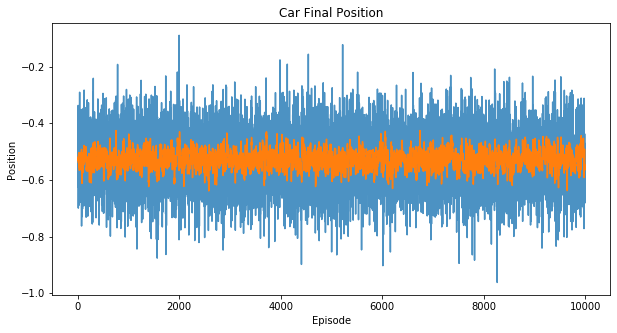

In [13]:
plot_last_positions(last_position_episodes)

In [14]:
def plot_rewards(ave_reward_list):
    plt.subplots(figsize=(10,5))
    plt.plot(100*(np.arange(len(ave_reward_list)) + 1), ave_reward_list)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward vs Episodes');

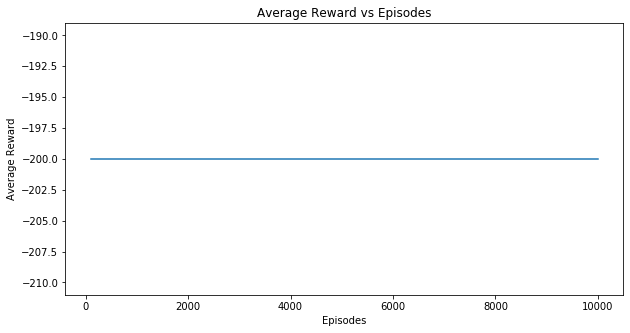

In [15]:
plot_rewards(ave_reward_list)

In [16]:
def plot_successes(successful):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.hist(successful, bins = int(EPISODES/500));
    ax.set_xlabel('Episodes');
    ax.set_ylabel('#Successful');
    print('successful episodes: {}'.format(np.count_nonzero(successful)))

successful episodes: 0


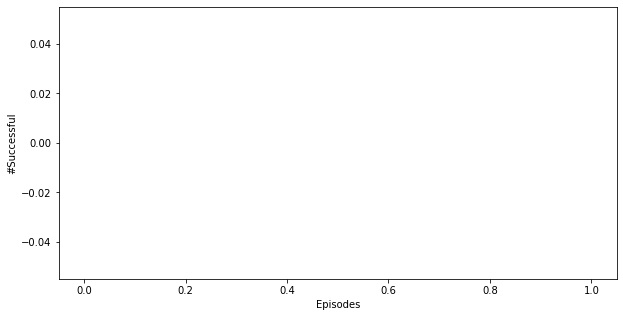

In [17]:
plot_successes(successful)

# Can you make it better?

- The collection of some produced variables are sent to us, and we will give you a SCORE

In [18]:
import hackathon_mad_hub_2101 as hack_tools

In [19]:
team = "YOUR TEAM NAME"

hack_tools.post_score(team, [ave_reward_list, successful, last_position_episodes])

"Score posted!"



[Leaderboard](https://hackathon-ing-mad-hub-2101.herokuapp.com/)
